In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from datetime import datetime
import random
import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.optimizers.legacy import Nadam
from tensorflow.keras.optimizers import AdamW
#from tensorflow.keras.optimizers.legacy import AdamW

from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer, Masking
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, regularizers
from keras.callbacks import EarlyStopping

In [3]:
sns.set_theme(rc={'figure.figsize':(16,8)})

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
from google.colab import files
uploaded = files.upload()

Saving 01_06_2021_to_20_06_2023_prepared_df_25.csv to 01_06_2021_to_20_06_2023_prepared_df_25.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_34.csv to 01_06_2021_to_20_06_2023_prepared_df_34.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_36.csv to 01_06_2021_to_20_06_2023_prepared_df_36.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_52.csv to 01_06_2021_to_20_06_2023_prepared_df_52.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_95.csv to 01_06_2021_to_20_06_2023_prepared_df_95.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_180.csv to 01_06_2021_to_20_06_2023_prepared_df_180.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_206.csv to 01_06_2021_to_20_06_2023_prepared_df_206.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_272.csv to 01_06_2021_to_20_06_2023_prepared_df_272.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_287.csv to 01_06_2021_to_20_06_2023_prepared_df_287.csv
Saving 01_06_2021_to_20_06_2023_prepared_df_368.csv to 01_06_2021_to_20_06_2023_prepared_df_368.csv
Saving 01_

In [5]:
csv_list = [25, 34, 36, 52, 95, 180, 206, 272, 287, 368, 781, 875, 1435, 5435, 6287]

In [6]:
df_dict = {}
for x in csv_list:
    df_dict[f"df_{x}"] = pd.read_csv(f'01_06_2021_to_20_06_2023_prepared_df_{x}.csv', parse_dates=[0], index_col=[0])

In [7]:
for key, value in df_dict.items():
  print(key)

df_25
df_34
df_36
df_52
df_95
df_180
df_206
df_272
df_287
df_368
df_781
df_875
df_1435
df_5435
df_6287


In [8]:
# Add pocket column with ones
for key, value in df_dict.items():
  df_dict[key][f'pocket {key}'] = 1


In [9]:
df_dict['df_25']

,nb_cars,nb_cars_cxl,nb_bookings,nb_bookings_cxl,hourly rate,WE package,1 week package,1 month package,other package,2 weeks package,...,0H à 6H,18H à 24H,+24h,06:00 24:00,00:30 06:00,00:00 00:30,strike,holidays,vacation,pocket df_25
date,,,,,,,,,,,,,,,,,,,,,
2021-06-01,6,0,5,0,1,0,4,1,0,0,...,1,1,6,0,0,0,0,0,0,1
2021-06-02,10,0,13,0,3,0,6,1,0,0,...,1,1,10,0,0,0,0,0,0,1
2021-06-03,15,0,6,0,7,0,7,1,0,0,...,1,1,15,0,0,0,0,0,0,1
2021-06-04,18,0,15,0,10,0,7,1,0,0,...,2,1,18,0,0,0,0,0,0,1
2021-06-05,18,0,5,1,6,9,3,0,0,0,...,0,0,18,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-16,37,4,32,4,21,3,11,2,0,0,...,3,0,37,0,0,0,0,0,0,1
2023-06-17,41,6,11,0,7,24,8,2,0,0,...,0,1,41,0,0,0,0,0,0,1
2023-06-18,40,5,2,0,3,26,7,4,0,0,...,0,1,40,0,0,0,0,0,0,1


In [10]:
#Create TGV list to concatenate
tgv_df = pd.concat([df_dict['df_25'],
           df_dict['df_36'],
           df_dict['df_272'],
           df_dict['df_287'],
           df_dict['df_781'],
           df_dict['df_875'],
           df_dict['df_1435'],
           df_dict['df_5435'],
           df_dict['df_6287']],
           ignore_index=True).fillna(0)

In [11]:
tgv_df

,nb_cars,nb_cars_cxl,nb_bookings,nb_bookings_cxl,hourly rate,WE package,1 week package,1 month package,other package,2 weeks package,...,vacation,pocket df_25,pocket df_36,pocket df_272,pocket df_287,pocket df_781,pocket df_875,pocket df_1435,pocket df_5435,pocket df_6287
0,6,0,5,0,1,0,4,1,0,0,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10,0,13,0,3,0,6,1,0,0,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,15,0,6,0,7,0,7,1,0,0,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,18,0,15,0,10,0,7,1,0,0,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,0,5,1,6,9,3,0,0,0,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6745,18,5,14,3,12,1,3,2,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6746,20,6,11,0,5,10,3,2,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6747,27,5,6,0,6,15,4,2,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6748,18,2,12,4,5,6,5,2,0,0,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [12]:
#Create list to concatenate
city_df = pd.concat([
           df_dict['df_34'],
           df_dict['df_52'],
           df_dict['df_95'],
           df_dict['df_180'],
           df_dict['df_206'],
           df_dict['df_368'],],
           ignore_index=True).fillna(0)

In [13]:
city_df

,nb_cars,nb_cars_cxl,nb_bookings,nb_bookings_cxl,hourly rate,WE package,1 week package,1 month package,other package,2 weeks package,...,00:00 00:30,strike,holidays,vacation,pocket df_34,pocket df_52,pocket df_95,pocket df_180,pocket df_206,pocket df_368
0,12,3,7,0,8,0,0,4,0,0,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
1,16,3,5,0,12,0,0,4,0,0,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
2,14,3,6,1,10,0,0,4,0,0,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
3,13,3,6,0,10,0,0,3,0,0,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
4,11,2,6,0,3,5,0,3,0,0,...,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,21,1,15,1,5,6,4,6,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4496,31,1,10,0,2,20,3,6,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4497,38,1,9,0,0,26,5,7,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4498,28,1,10,0,2,10,8,8,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
# This function will create a slice of data from a specified random starting position.
# The random position must be generated externally.

def get_Xi_yi(df_X,
              df_y,
              random_start,
              X_length=28,
              y_length=7):

#     must define a random_start:int for function to run
    Xi = df_X.iloc[random_start-X_length:random_start]
    yi = df_y.iloc[random_start:random_start+y_length]

    return Xi, yi


In [15]:
# The main data selection function.
# This function will generate all random slices based on the length of the dataframe passed.
# Important to note, if val state is set to true, it will only generate data slices after the val_cutoff point.

def get_X_y(df,
            X_length=56,
            y_length=14,
            number_of_sequences=51,
            number_of_targets=1,
            n_pca=30,
            val=False,
            val_cutoff=0.8):

#     limit dataframes to length for train/test splits
    df_X = df.copy()
    df_y = df.iloc[:, :number_of_targets].copy()

#     convert and scale X dataframe to PCA to solve dimensionality problem
    scaler = MinMaxScaler()
    df_X_scaled = scaler.fit_transform(df_X)
    pca = PCA(n_components=n_pca).fit(df_X_scaled)
    df_X_proj = pd.DataFrame(pca.transform(df_X_scaled))
    df_X_proj.index = df_X.index

#     create unique list to sample random datapoints from
    if val:
        sample_list = list(range(int(len(df_y)*val_cutoff), int(len(df_y)-y_length)))
    if not val:
        sample_list = list(range(int(X_length), int(len(df_y)-y_length)))
    random.shuffle(sample_list)

#     empty lists to append data to, will create 3D dataframe here
    X, y = [], []

#     for loop to select ith values from data
    for i in range(number_of_sequences):
        Xi, yi = get_Xi_yi(df_X_proj, df_y, sample_list.pop(-1), X_length, y_length)
        X.append(Xi.values.tolist())
        y.append(yi.values.tolist())

    return np.array(X), np.array(y)

In [16]:
# Create X_train, y_train
tgv_X_train, tgv_y_train = get_X_y(tgv_df.iloc[:int(len(tgv_df)*0.6)],
                            X_length=56,
                            y_length=14,
                            number_of_sequences=50,
                            number_of_targets=1)

In [17]:
# Create X_train, y_train
city_X_train, city_y_train = get_X_y(city_df.iloc[:int(len(city_df)*0.6)],
                            X_length=56,
                            y_length=14,
                            number_of_sequences=50,
                            number_of_targets=1)

In [18]:
tgv_y_train = tgv_y_train[:, :, 0]
city_y_train = city_y_train[:, :, 0]


In [19]:
print(city_X_train.shape, city_y_train.shape)

(50, 56, 30) (50, 14)


In [20]:
# Define X_val, y_val
tgv_X_val, tgv_y_val = get_X_y(tgv_df.iloc[:int(len(tgv_df)*0.8)],
                       X_length=56,
                       y_length=14,
                       number_of_sequences=15,
                       number_of_targets=1,
                       val=True,
                       val_cutoff=0.6)

In [21]:
# Define X_val, y_val
city_X_val, city_y_val = get_X_y(city_df.iloc[:int(len(city_df)*0.8)],
                       X_length=56,
                       y_length=14,
                       number_of_sequences=15,
                       number_of_targets=1,
                       val=True,
                       val_cutoff=0.6)

In [22]:
tgv_y_val = tgv_y_val[:, :, 0]
city_y_val = city_y_val[:, :, 0]

In [23]:
print(tgv_X_val.shape, tgv_y_val.shape)

(15, 56, 30) (15, 14)


In [24]:
# Define X_test, y_tes
tgv_X_test, tgv_y_test = get_X_y(tgv_df.iloc[:int(len(tgv_df)*0.99)],
                         X_length=56,
                         y_length=14,
                         number_of_sequences=15,
                         number_of_targets=1,
                         val=True,
                         val_cutoff=0.8)

In [25]:
# Define X_test, y_tes
city_X_test, city_y_test = get_X_y(city_df.iloc[:int(len(city_df)*0.99)],
                         X_length=56,
                         y_length=14,
                         number_of_sequences=15,
                         number_of_targets=1,
                         val=True,
                         val_cutoff=0.8)

In [26]:
city_y_test = city_y_test[:, :, 0]
tgv_y_test =tgv_y_test[:, :, 0]

In [27]:
print(city_X_test.shape, city_y_test.shape)

(15, 56, 30) (15, 14)


In [28]:
# y normalize
tgv_y_scaler = MinMaxScaler()
tgv_y_scaler.fit(tgv_y_train)

tgv_y_train_scaled = tgv_y_scaler.transform(tgv_y_train)
tgv_y_test_scaled = tgv_y_scaler.transform(tgv_y_test)
tgv_y_val_scaled = tgv_y_scaler.transform(tgv_y_val)

In [29]:
# y normalize
city_y_scaler = MinMaxScaler()
city_y_scaler.fit(city_y_train)

city_y_train_scaled = city_y_scaler.transform(city_y_train)
city_y_test_scaled = city_y_scaler.transform(city_y_test)
city_y_val_scaled = city_y_scaler.transform(city_y_val)

In [30]:
tgv_input_shape = tgv_X_train.shape[1:]
tgv_output_shape = tgv_y_train_scaled.shape[1]
tgv_reg = regularizers.l1_l2(l1=0.04, l2=0.02)

In [31]:
tgv_input_shape

(56, 30)

In [32]:
tgv_X_train

array([[[ 9.23973177e-01, -5.42046754e-01, -2.48604994e-01, ...,
          1.12464392e-02,  1.69025434e-17,  6.82470607e-17],
        [ 9.37966256e-01, -5.45957830e-01, -2.40020042e-01, ...,
          2.87593629e-02, -3.86086078e-17,  1.23758212e-16],
        [ 1.11854323e+00,  4.39156410e-01, -1.78667931e-01, ...,
          2.50622862e-02, -6.63641834e-17,  1.51513788e-16],
        ...,
        [ 8.71216082e-01, -5.36959215e-01, -2.63616064e-01, ...,
         -3.64063212e-02, -1.08530322e-17,  1.51513788e-16],
        [ 8.86410057e-01, -5.31444159e-01, -2.70859237e-01, ...,
         -2.13781124e-02, -6.63641834e-17,  1.23758212e-16],
        [ 8.99631646e-01, -5.36659960e-01, -2.61888399e-01, ...,
          1.35016207e-03, -3.86086078e-17,  9.60026363e-17]],

       [[ 8.13549437e-01, -5.29111089e-01, -2.68039095e-01, ...,
          1.79976540e-02, -3.86086078e-17,  9.60026363e-17],
        [ 8.30785337e-01, -5.34586412e-01, -2.62090012e-01, ...,
         -3.15598883e-02, -1.08530322e

In [33]:
city_input_shape = city_X_train.shape[1:]
city_output_shape = city_y_train_scaled.shape[1]
city_reg = regularizers.l1_l2(l1=0.04, l2=0.02)

In [34]:
# instantiate model
tgv_model = Sequential()

# masking
#tgv_model.add(layers.Masking(mask_value=-1000, input_shape = (56, 30)))

# model.add(Masking(input_shape = input_shape))
#tgv_input_shape

# hidden layer architecture
tgv_model.add(LSTM(200, return_sequences=True,\
              input_shape = city_input_shape))

tgv_model.add(LSTM(200, return_sequences=True,
               recurrent_regularizer=tgv_reg,
              # dropout=0.2
              ))

tgv_model.add(LSTM(200, return_sequences=True,
               recurrent_regularizer=tgv_reg,
              # dropout=0.2
              ))

tgv_model.add(LSTM(200, return_sequences=True,
               recurrent_regularizer=tgv_reg,
              # dropout=0.2
              ))

# pass final sequences
tgv_model.add(LSTM(200, return_sequences=False))

#can add dense layer
#droput layers/ recurrent dropout
#regularizers

# prediction layer
tgv_model.add(Dense(tgv_output_shape, activation = 'linear'))

In [35]:
# instantiate model
city_model = Sequential()

# masking
# model.add(Masking(input_shape = input_shape))

# hidden layer architecture
city_model.add(LSTM(200, return_sequences=True,\
              input_shape = city_input_shape))

city_model.add(LSTM(200, return_sequences=True,
               recurrent_regularizer=city_reg,
              # dropout=0.2
              ))

city_model.add(LSTM(200, return_sequences=True,
               recurrent_regularizer=city_reg,
              # dropout=0.2
              ))

city_model.add(LSTM(200, return_sequences=True,
               recurrent_regularizer=city_reg,
              # dropout=0.2
              ))

# pass final sequences
city_model.add(LSTM(200, return_sequences=False))

#can add dense layer
#droput layers/ recurrent dropout
#regularizers

# prediction layer
city_model.add(Dense(city_output_shape, activation = 'linear'))

In [36]:
optimizer = AdamW(learning_rate=0.01,
                  beta_1=0.8,
                  beta_2=0.999)
    #learning_rate=0.00003,
                 # beta_1=0.8,
                  #epsilon=1e-18)

In [37]:
tgv_model.compile(
    loss=['logcosh'],
    metrics=['mae'],
    optimizer=optimizer
)

es = EarlyStopping(
    patience=20,
    restore_best_weights=True
)

tgv_history = tgv_model.fit(
                tgv_X_train,
                tgv_y_train_scaled,
                batch_size = 32,
                epochs = 500,
                shuffle = False,
                verbose = 2,
                validation_data = (tgv_X_val, tgv_y_val_scaled),
                callbacks=[es]
)

Epoch 1/500
2/2 - 17s - loss: 498.8334 - mae: 0.1945 - val_loss: 284.0392 - val_mae: 0.2917 - 17s/epoch - 8s/step
Epoch 2/500
2/2 - 1s - loss: 256.2304 - mae: 0.2742 - val_loss: 163.5741 - val_mae: 0.9577 - 1s/epoch - 689ms/step
Epoch 3/500
2/2 - 2s - loss: 152.9859 - mae: 0.8006 - val_loss: 118.2466 - val_mae: 0.4401 - 2s/epoch - 884ms/step
Epoch 4/500
2/2 - 2s - loss: 111.5014 - mae: 0.3982 - val_loss: 94.3091 - val_mae: 0.3558 - 2s/epoch - 1s/step
Epoch 5/500
2/2 - 2s - loss: 90.2179 - mae: 0.2971 - val_loss: 75.3258 - val_mae: 0.2575 - 2s/epoch - 885ms/step
Epoch 6/500
2/2 - 1s - loss: 73.9050 - mae: 0.2274 - val_loss: 61.3883 - val_mae: 0.2167 - 1s/epoch - 688ms/step
Epoch 7/500
2/2 - 1s - loss: 59.0699 - mae: 0.2121 - val_loss: 55.1584 - val_mae: 0.2031 - 1s/epoch - 699ms/step
Epoch 8/500
2/2 - 1s - loss: 52.6950 - mae: 0.1901 - val_loss: 44.7803 - val_mae: 0.1889 - 1s/epoch - 684ms/step
Epoch 9/500
2/2 - 1s - loss: 43.7324 - mae: 0.1787 - val_loss: 41.1842 - val_mae: 0.1782 - 1s

In [38]:
optimizer = AdamW(learning_rate=0.01,
                  beta_1=0.8,
                  beta_2=0.999)
    #learning_rate=0.00003,
                 # beta_1=0.8,
                  #epsilon=1e-18)

In [39]:
city_model.compile(
    loss=['logcosh'],
    metrics=['mae'],
    optimizer=optimizer
)

es = EarlyStopping(
    patience=20,
    restore_best_weights=True
)

city_history = city_model.fit(
                city_X_train,
                city_y_train_scaled,
                batch_size = 32,
                epochs = 500,
                shuffle = False,
                verbose = 2,
                validation_data = (city_X_val, city_y_val_scaled),
                callbacks=[es]
)

Epoch 1/500
2/2 - 14s - loss: 498.6268 - mae: 0.3610 - val_loss: 284.3311 - val_mae: 0.7041 - 14s/epoch - 7s/step
Epoch 2/500
2/2 - 1s - loss: 256.5787 - mae: 0.7503 - val_loss: 163.4193 - val_mae: 0.3477 - 1s/epoch - 683ms/step
Epoch 3/500
2/2 - 2s - loss: 152.9493 - mae: 0.3487 - val_loss: 118.5046 - val_mae: 0.4225 - 2s/epoch - 915ms/step
Epoch 4/500
2/2 - 2s - loss: 111.6727 - mae: 0.3848 - val_loss: 94.3616 - val_mae: 0.3497 - 2s/epoch - 1s/step
Epoch 5/500
2/2 - 2s - loss: 90.2727 - mae: 0.2557 - val_loss: 75.3916 - val_mae: 0.3080 - 2s/epoch - 831ms/step
Epoch 6/500
2/2 - 1s - loss: 73.8923 - mae: 0.2218 - val_loss: 61.3254 - val_mae: 0.2800 - 1s/epoch - 687ms/step
Epoch 7/500
2/2 - 1s - loss: 59.0414 - mae: 0.2026 - val_loss: 55.2655 - val_mae: 0.2690 - 1s/epoch - 677ms/step
Epoch 8/500
2/2 - 1s - loss: 52.7208 - mae: 0.1768 - val_loss: 44.7463 - val_mae: 0.2610 - 1s/epoch - 666ms/step
Epoch 9/500
2/2 - 1s - loss: 43.6811 - mae: 0.1611 - val_loss: 41.2464 - val_mae: 0.3495 - 1s

In [40]:
tgv_X_test.shape

(15, 56, 30)

In [41]:
tgv_y_pred = tgv_model.predict(tgv_X_test)

tgv_y_pred = tgv_y_scaler.inverse_transform(tgv_y_pred)


1/1 [==============================] - 2s 2s/step


In [42]:
city_y_pred = city_model.predict(city_X_test)

city_y_pred = city_y_scaler.inverse_transform(city_y_pred)


1/1 [==============================] - 2s 2s/step


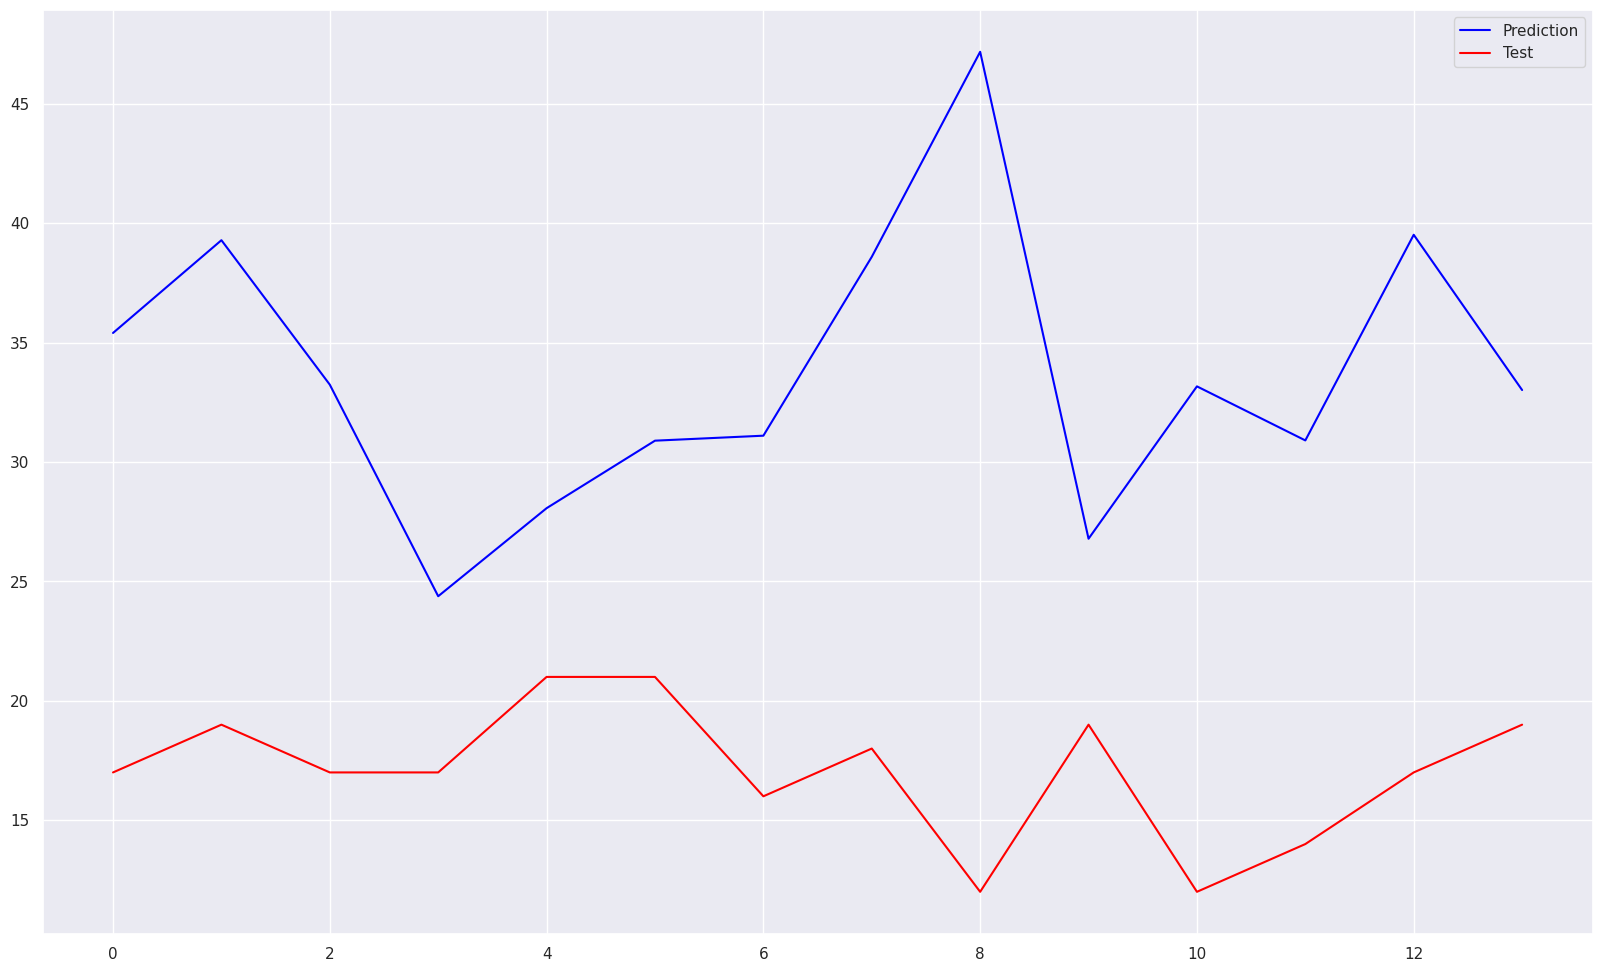

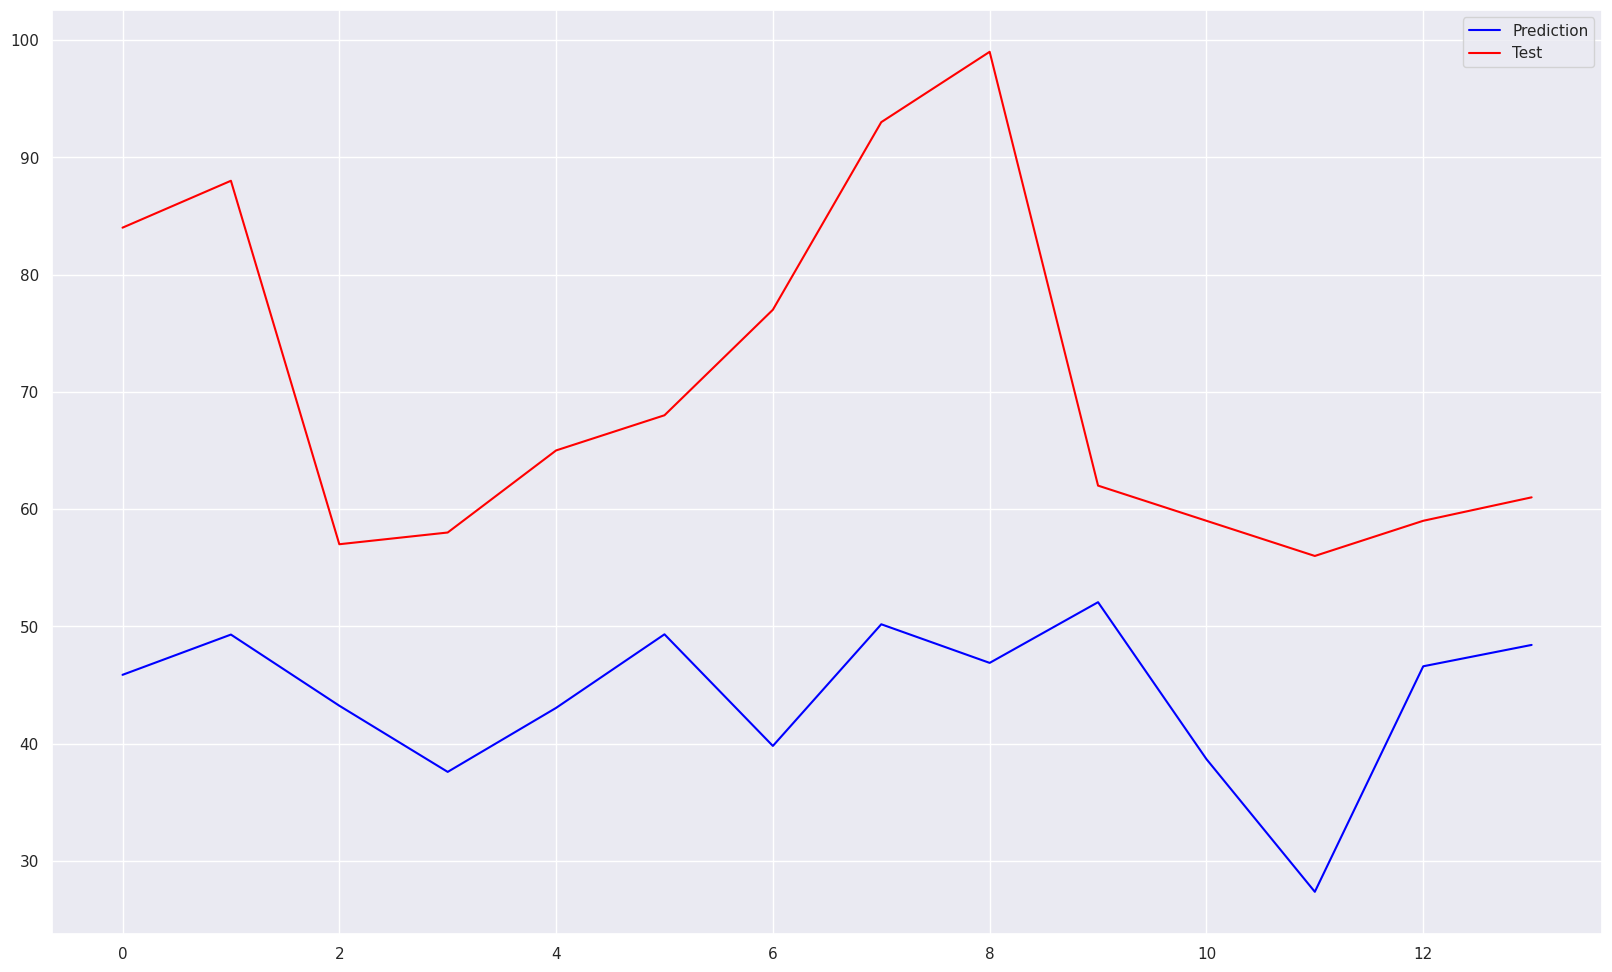

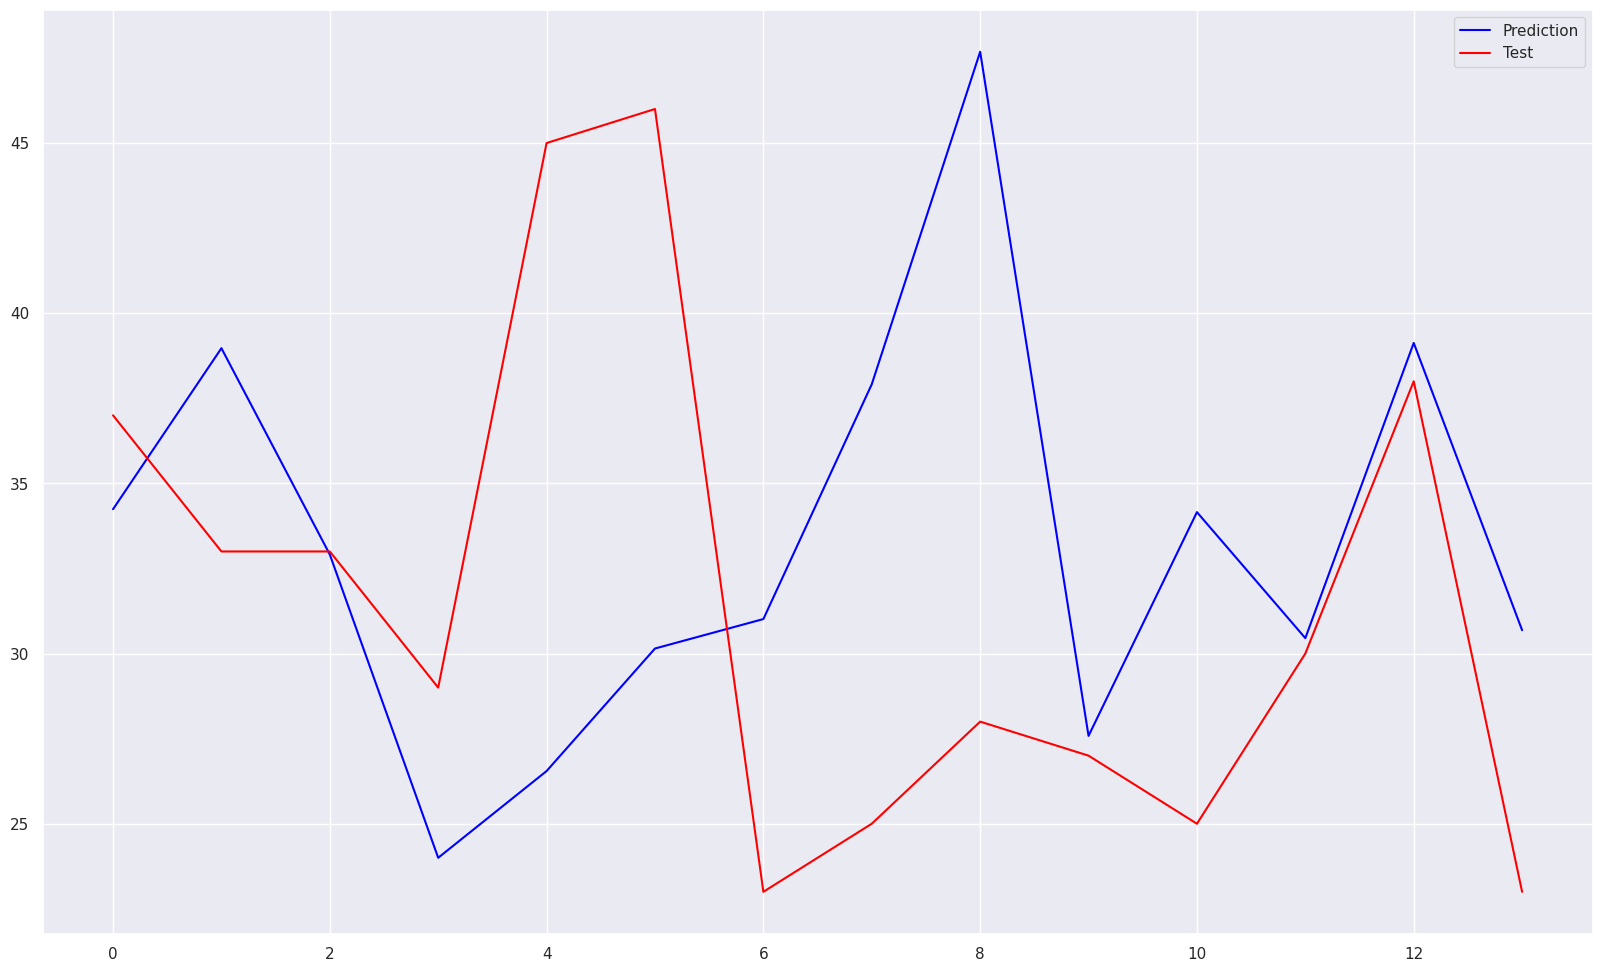

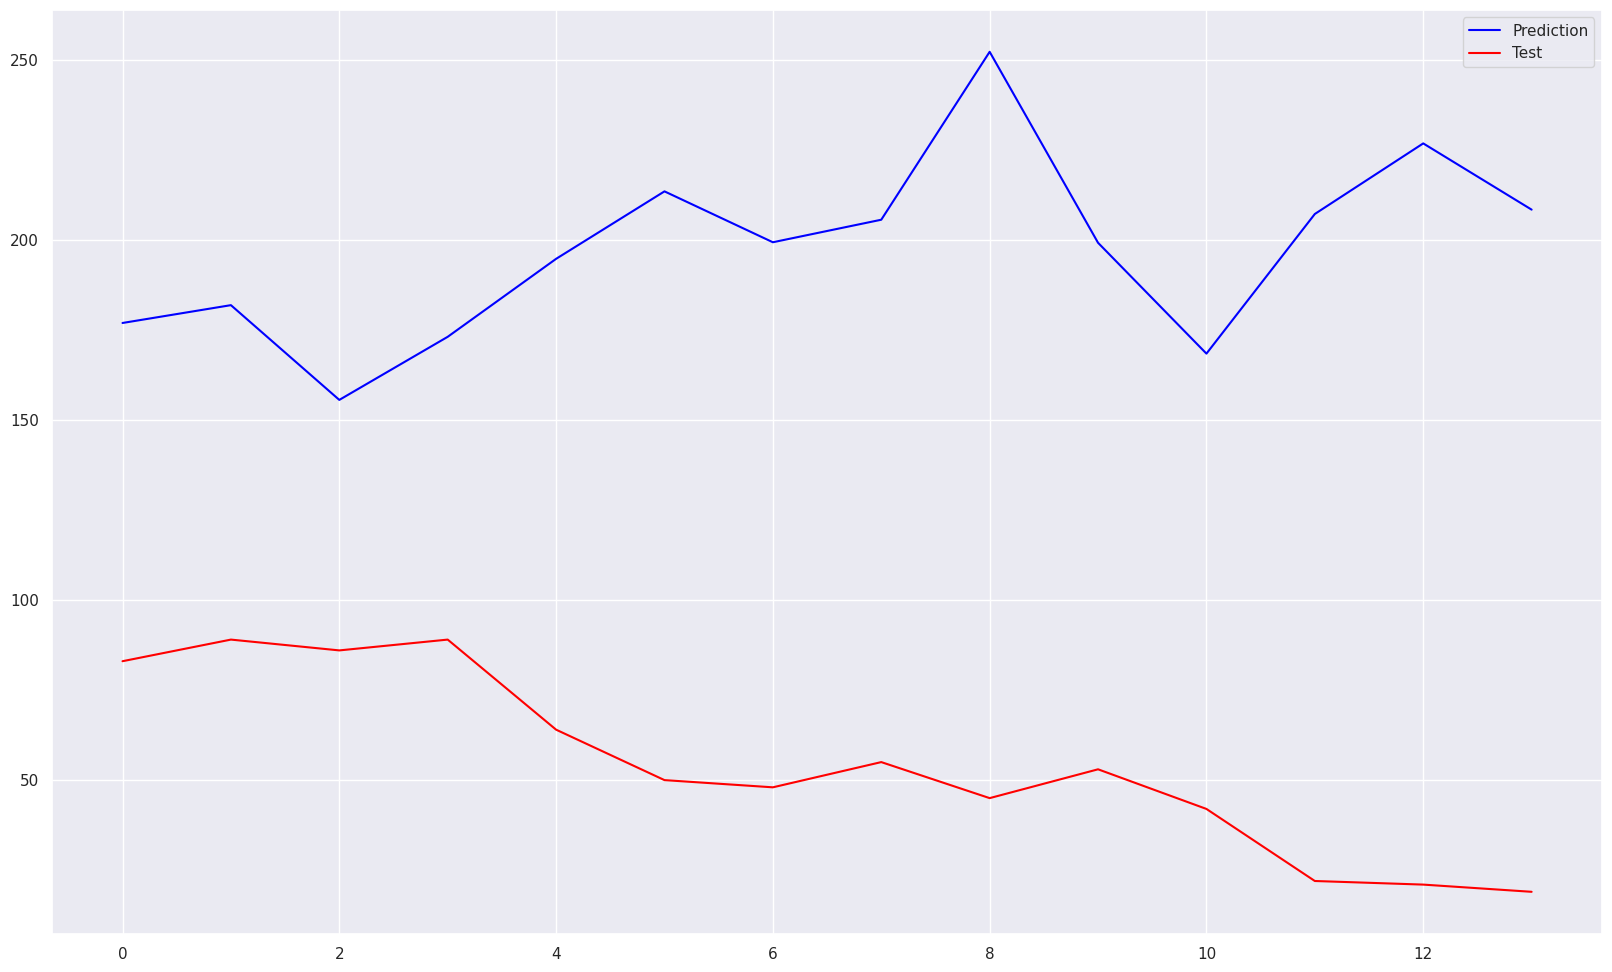

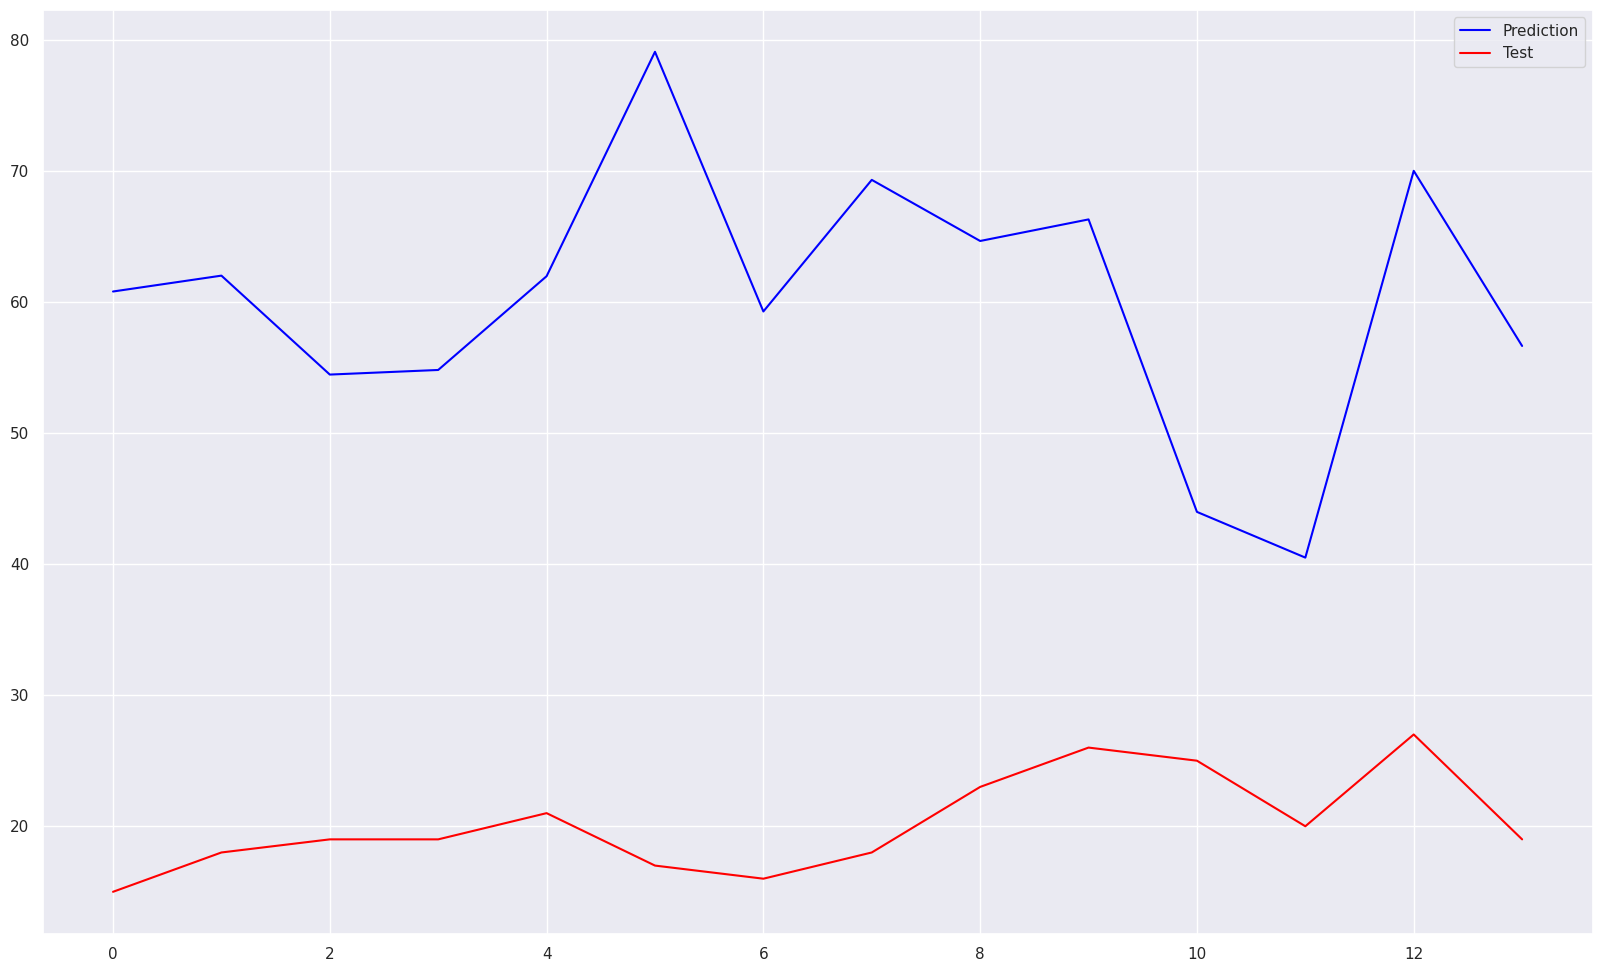

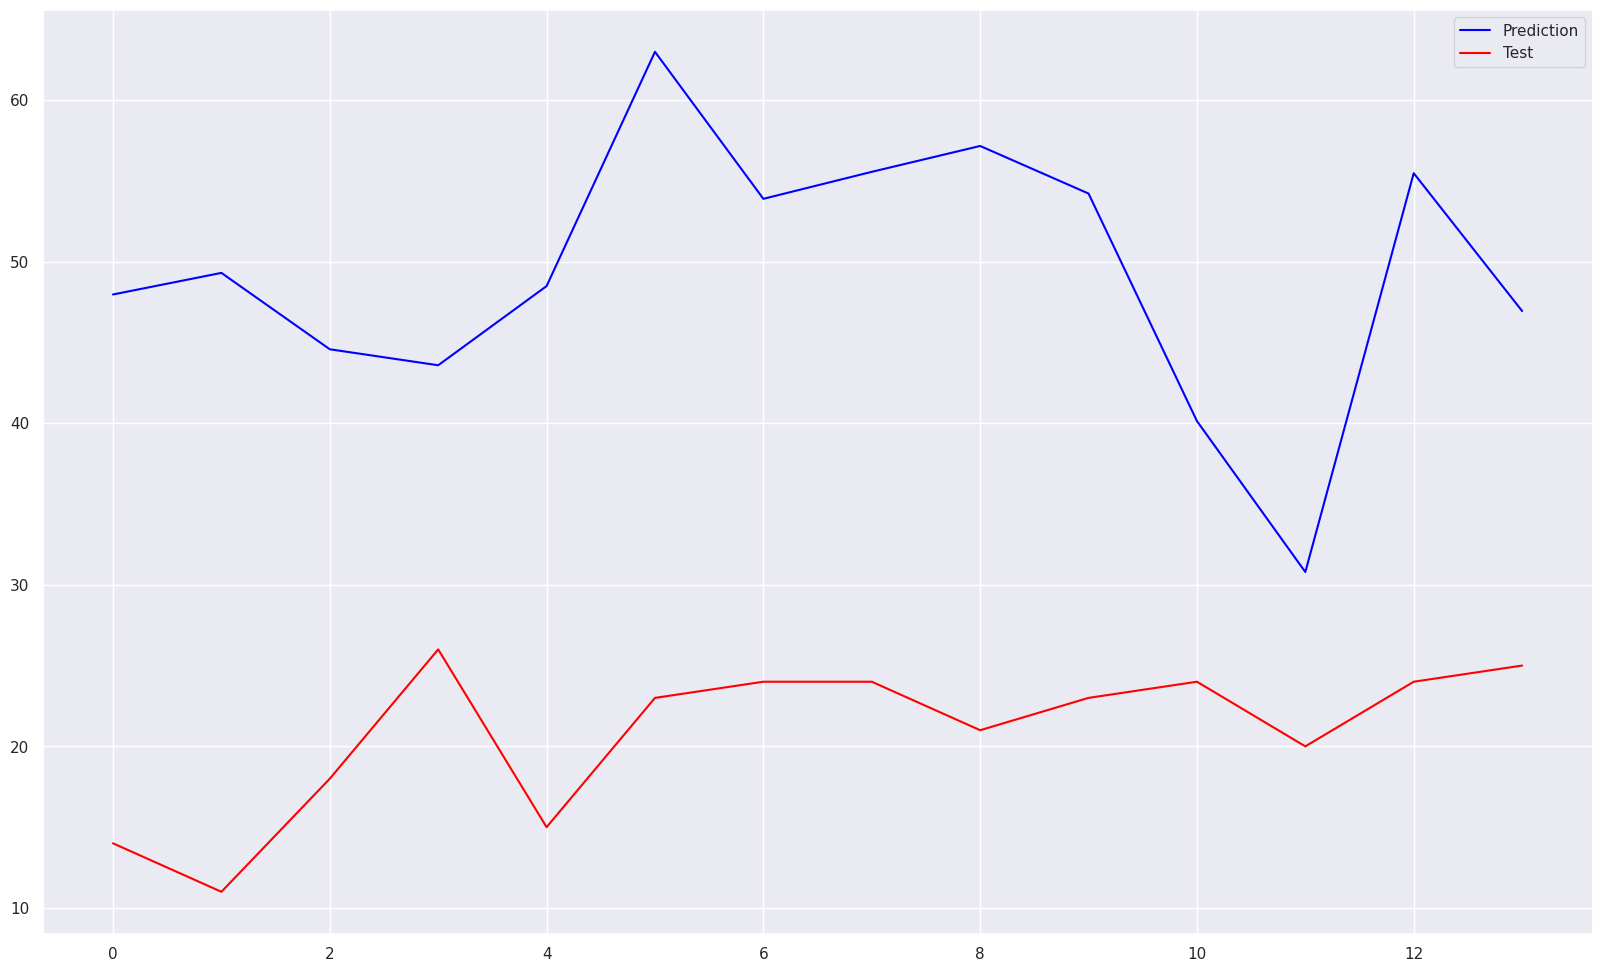

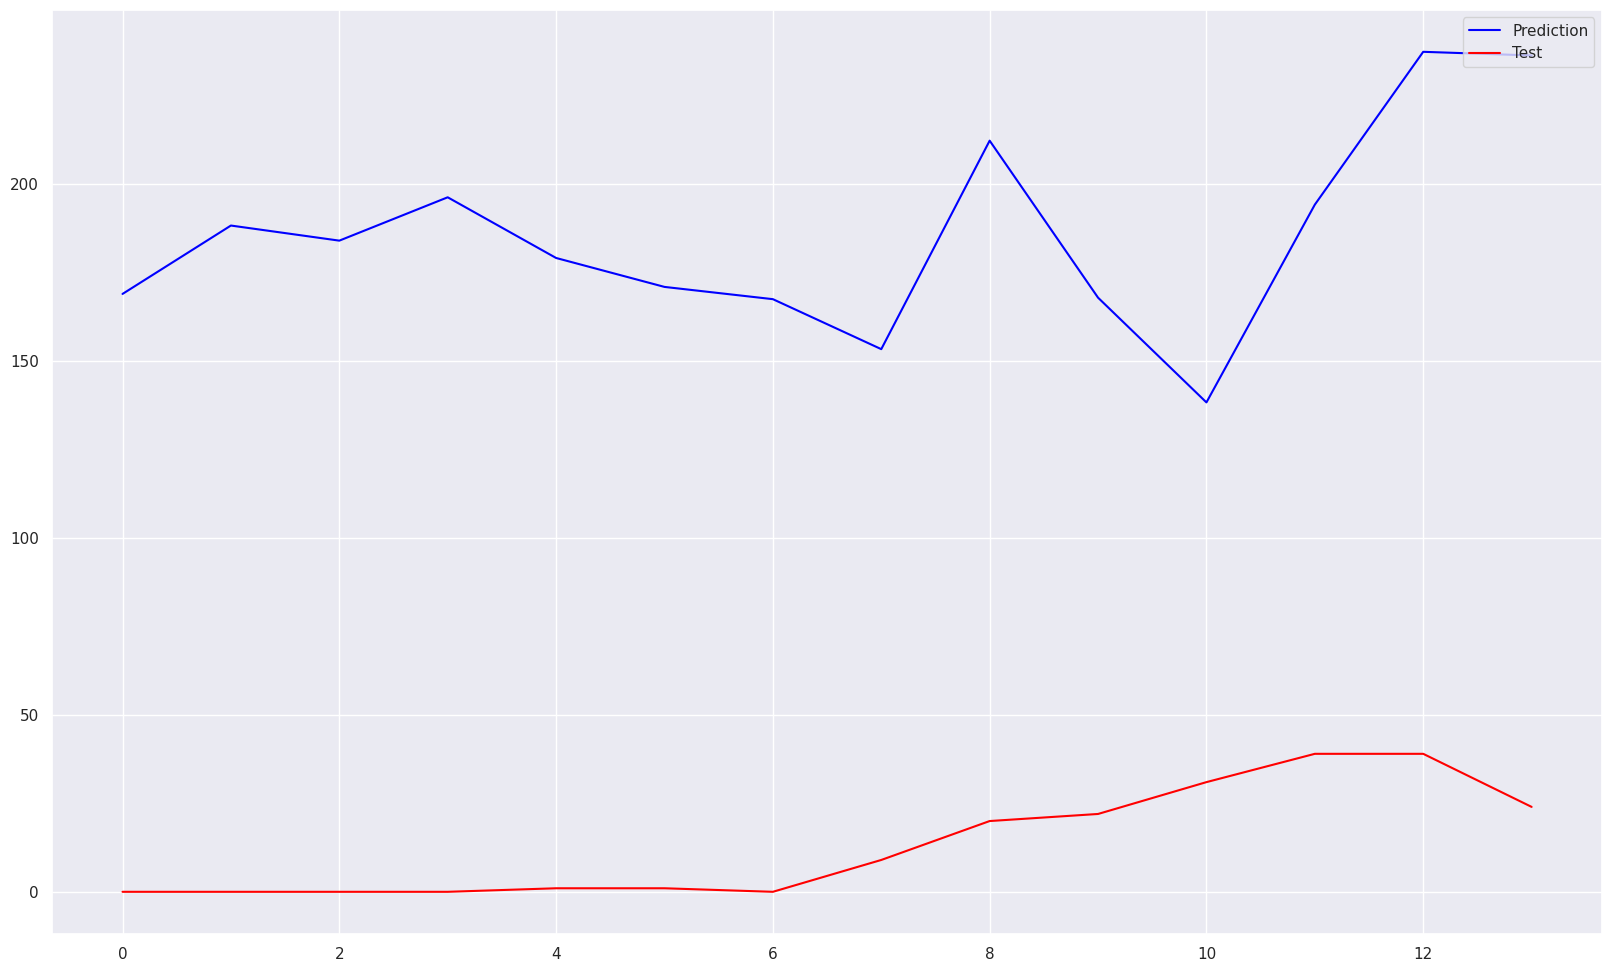

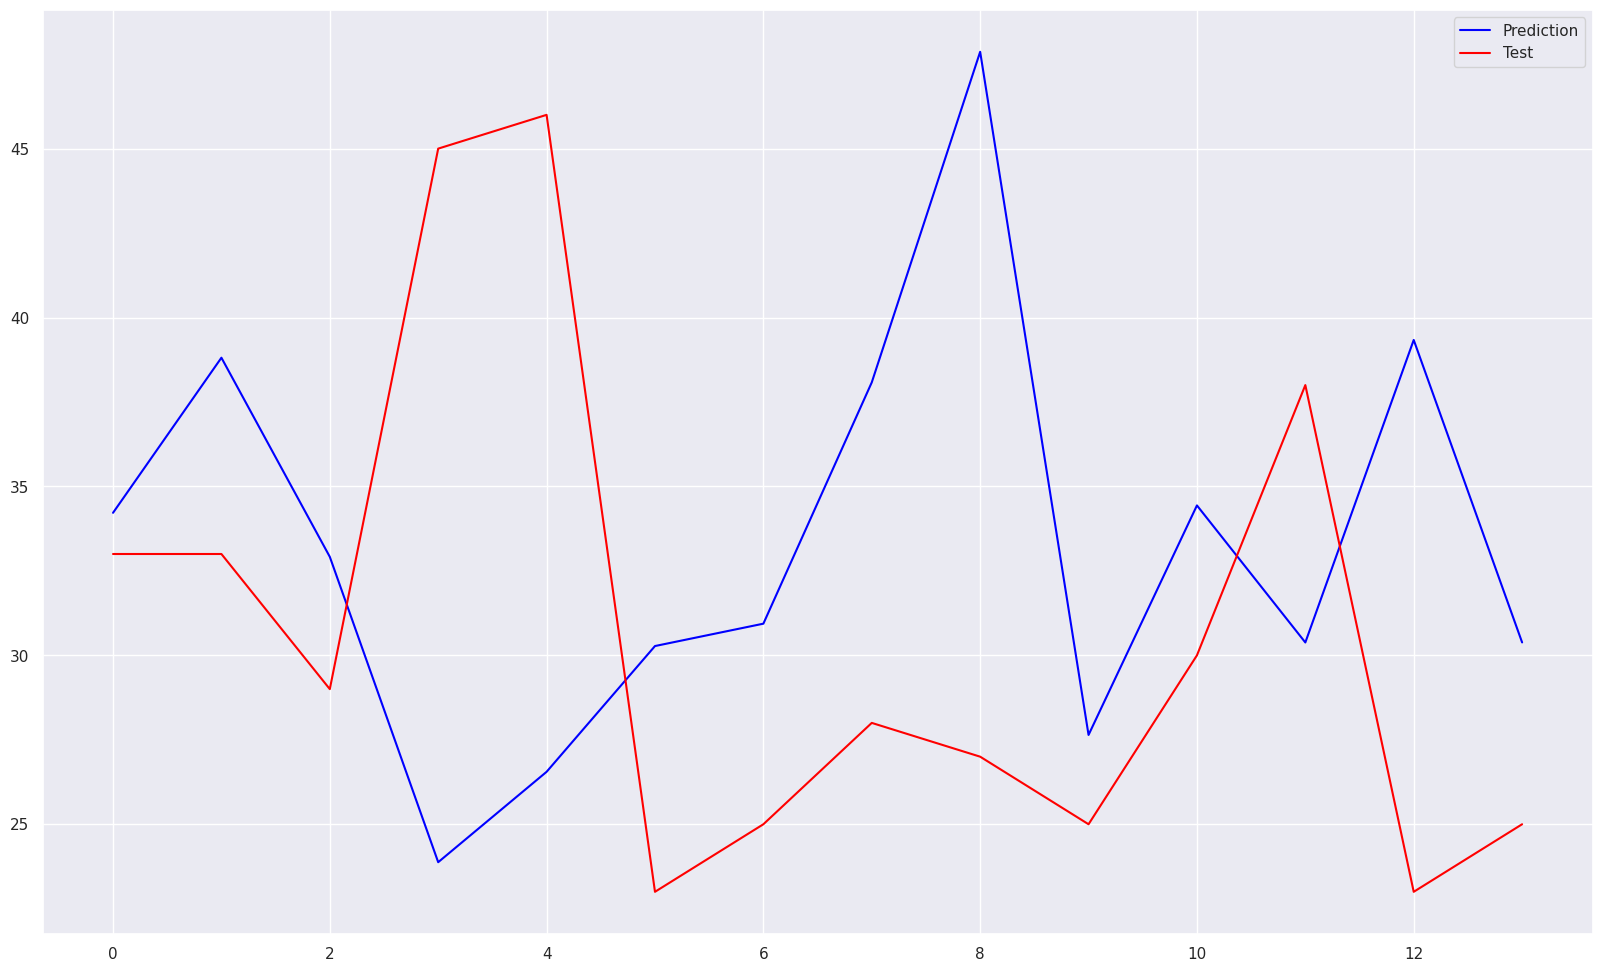

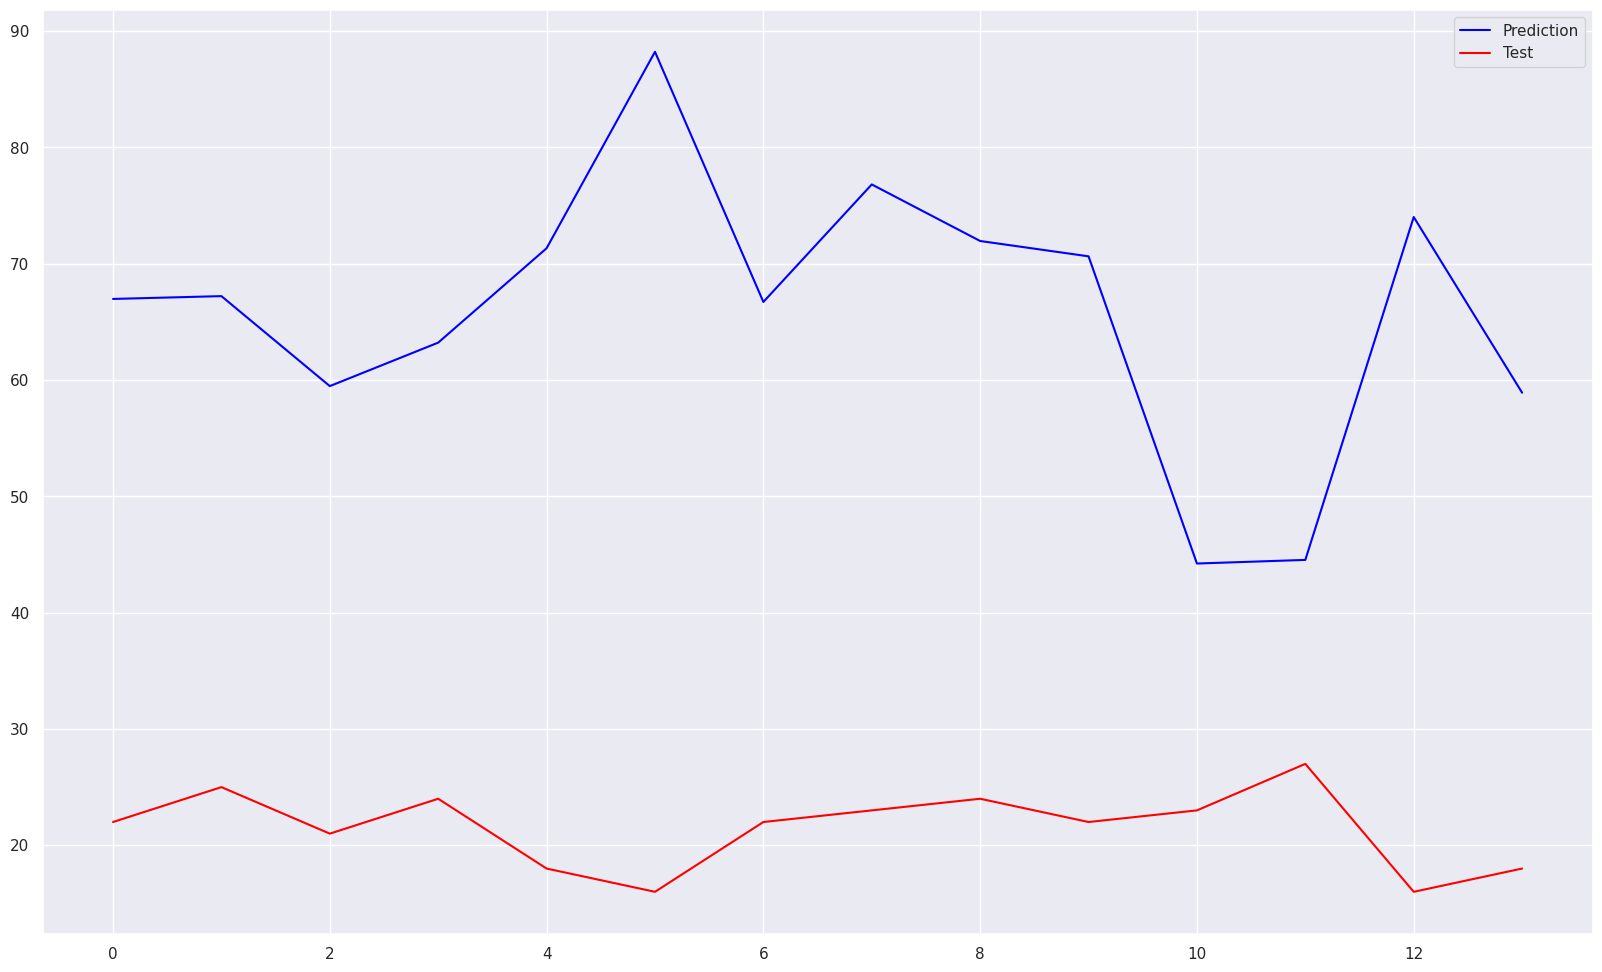

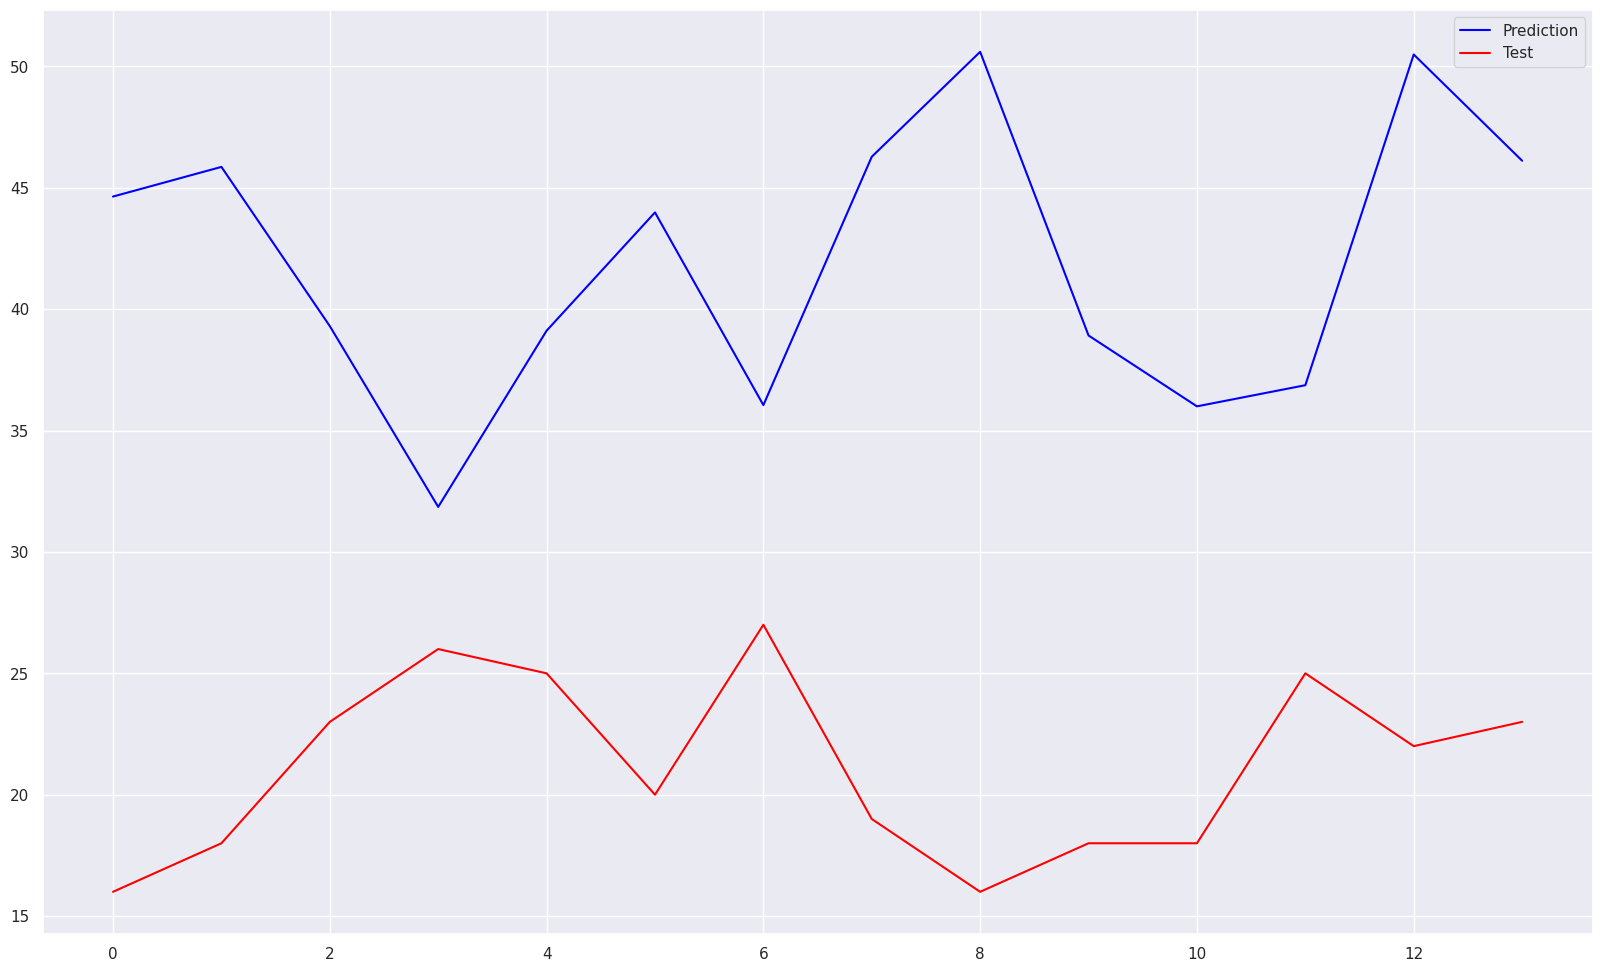

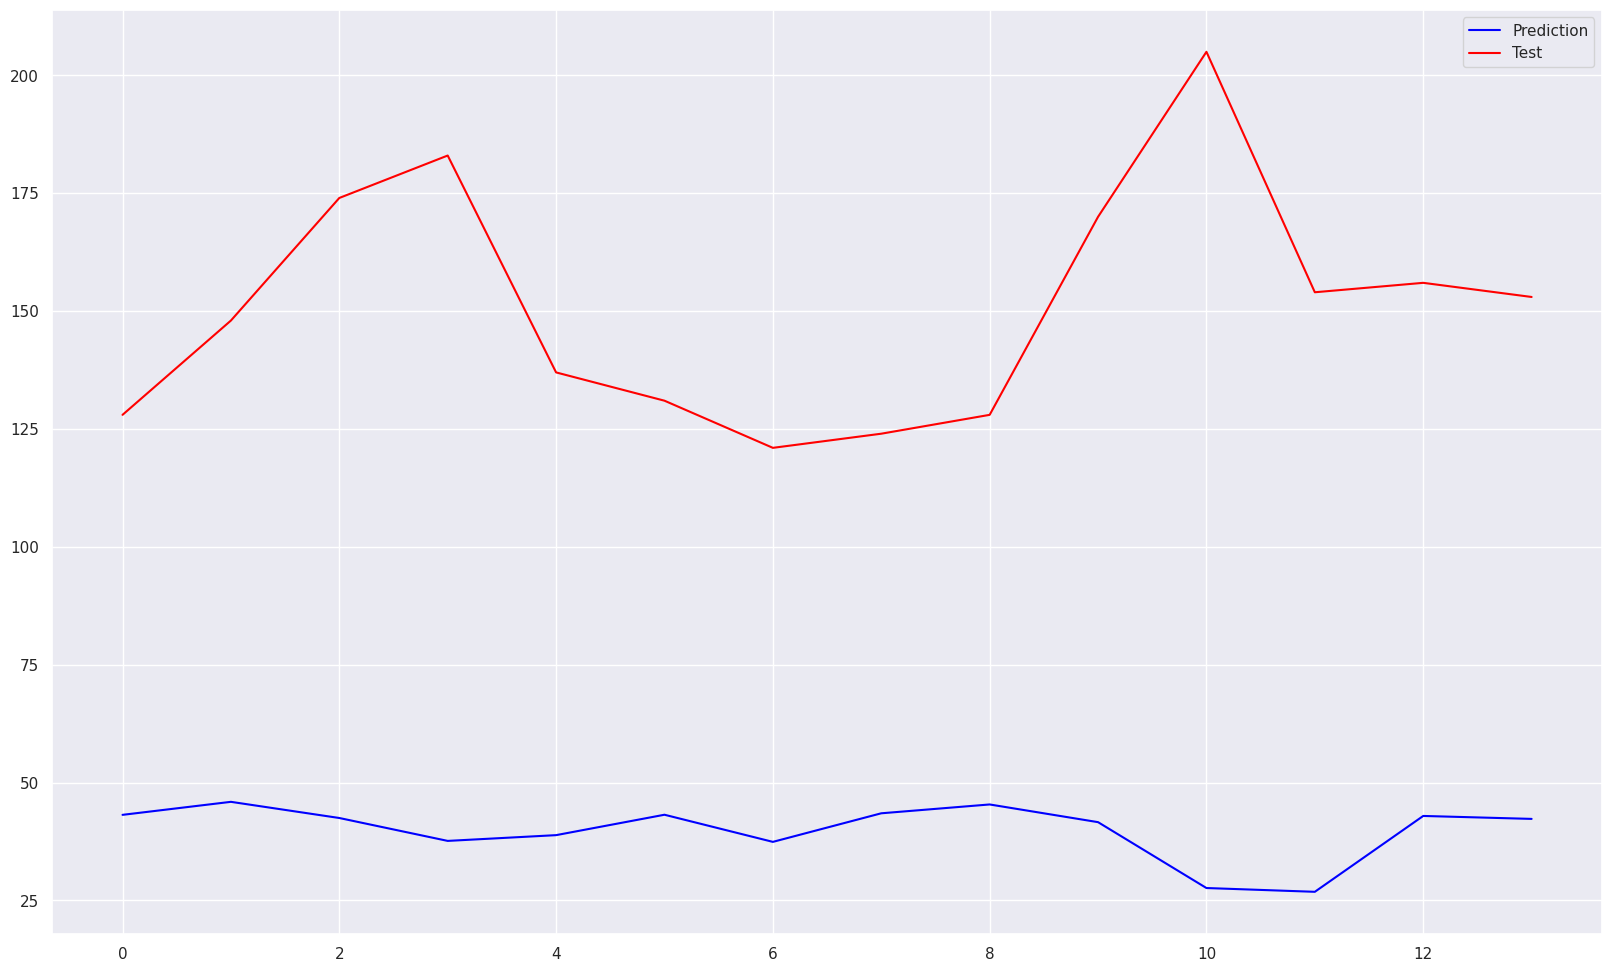

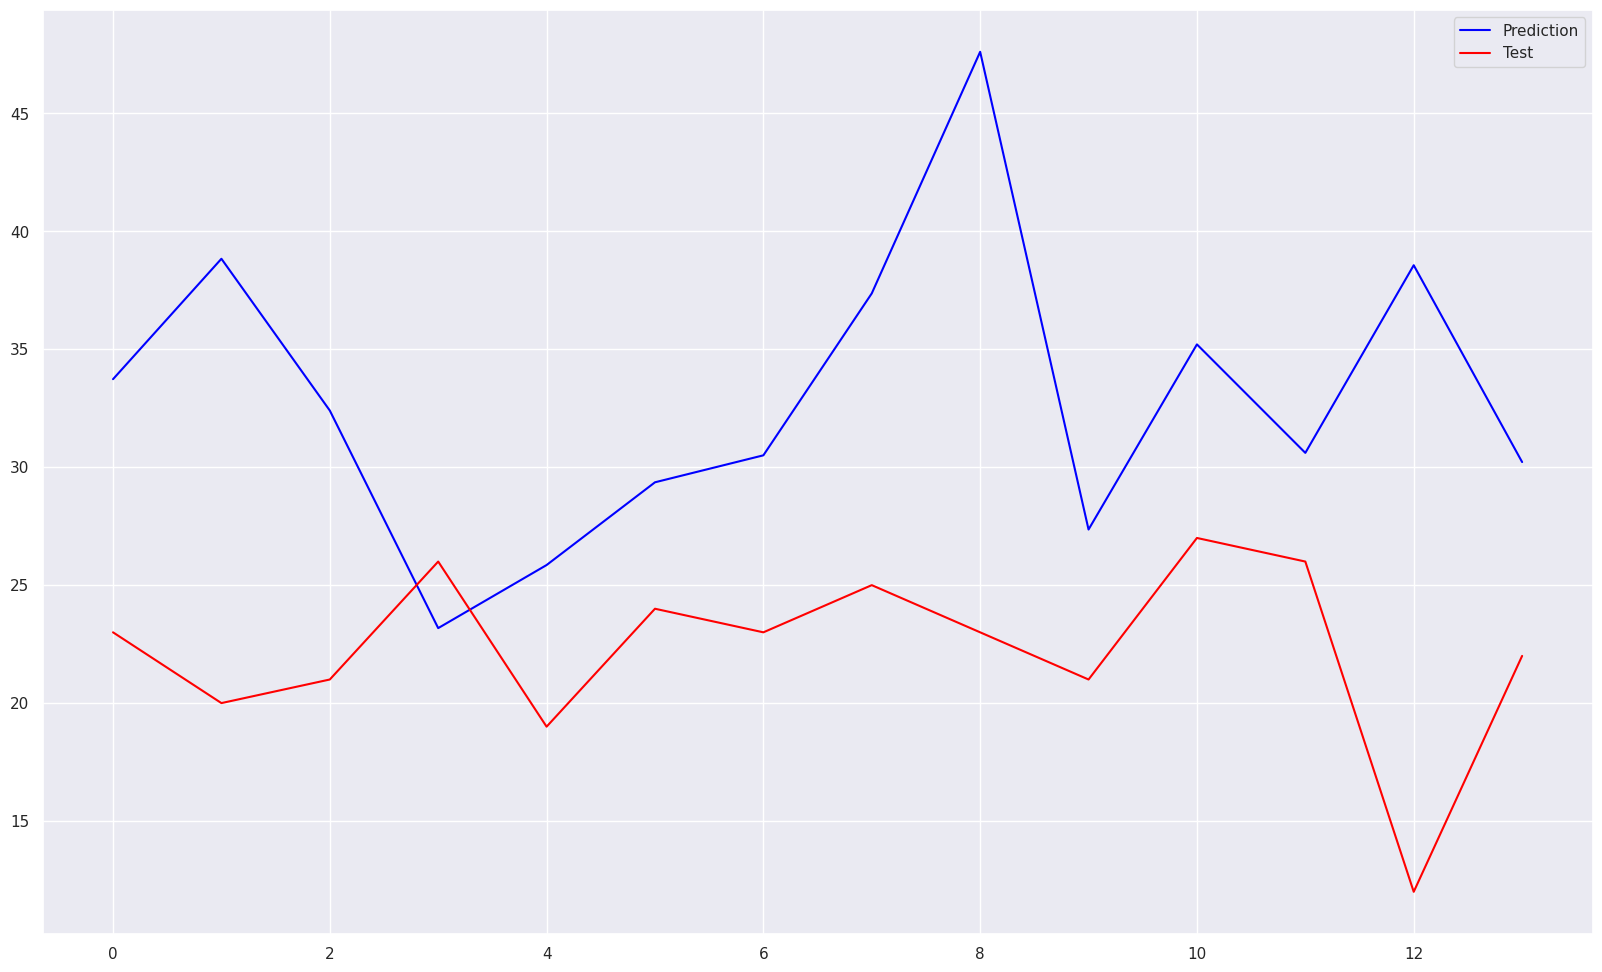

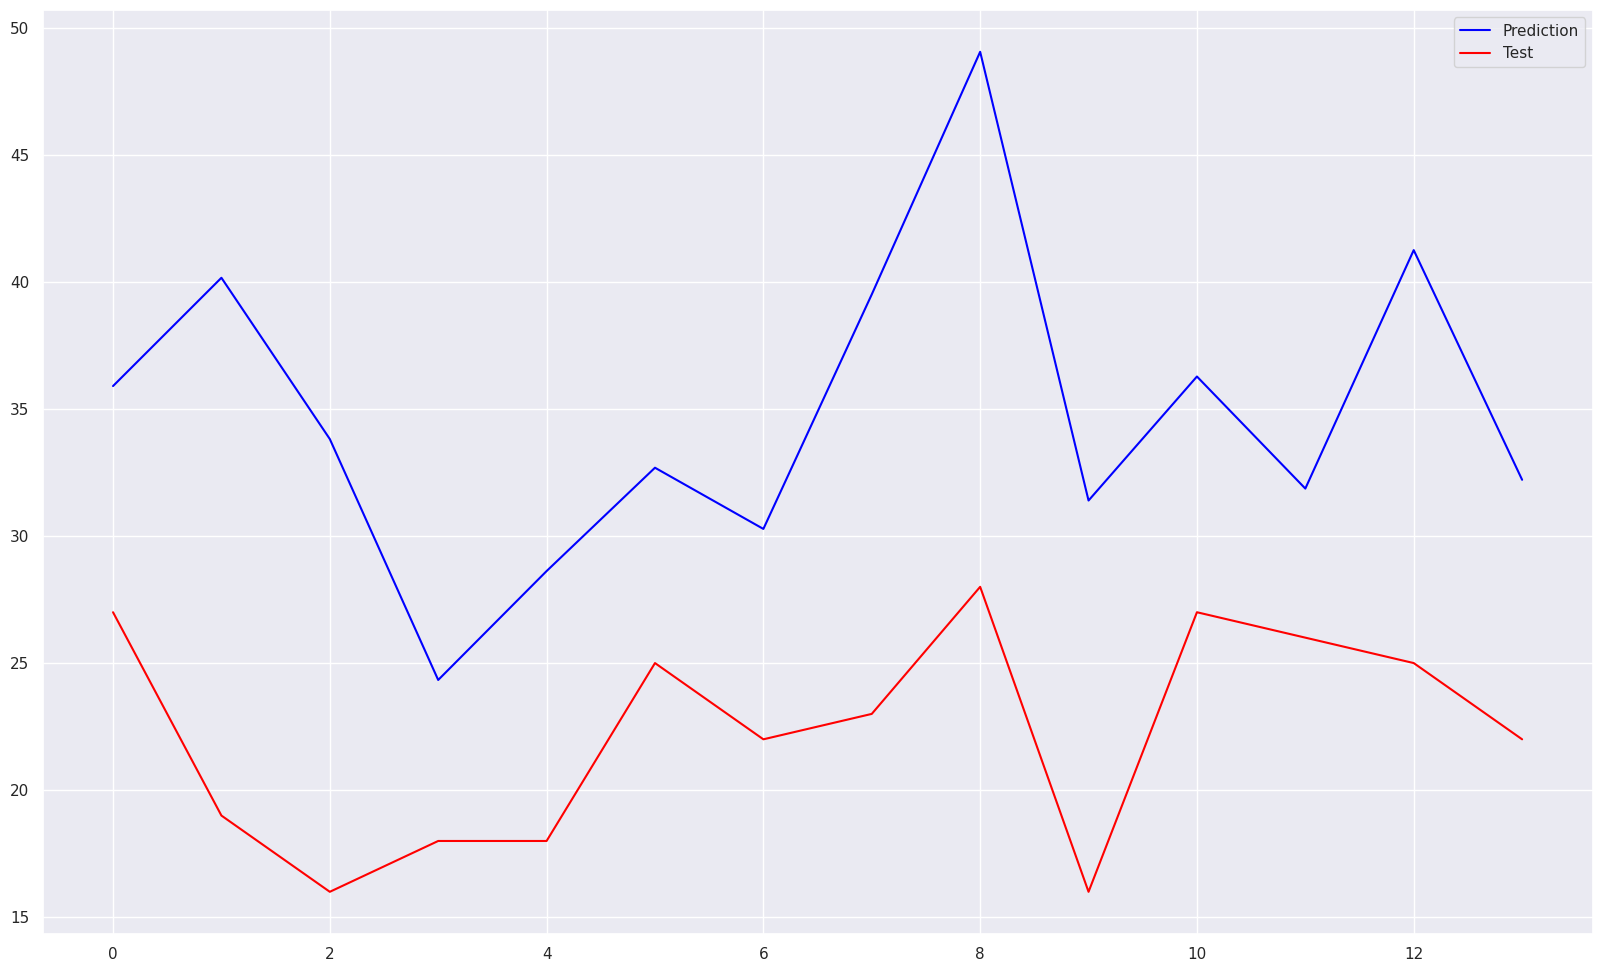

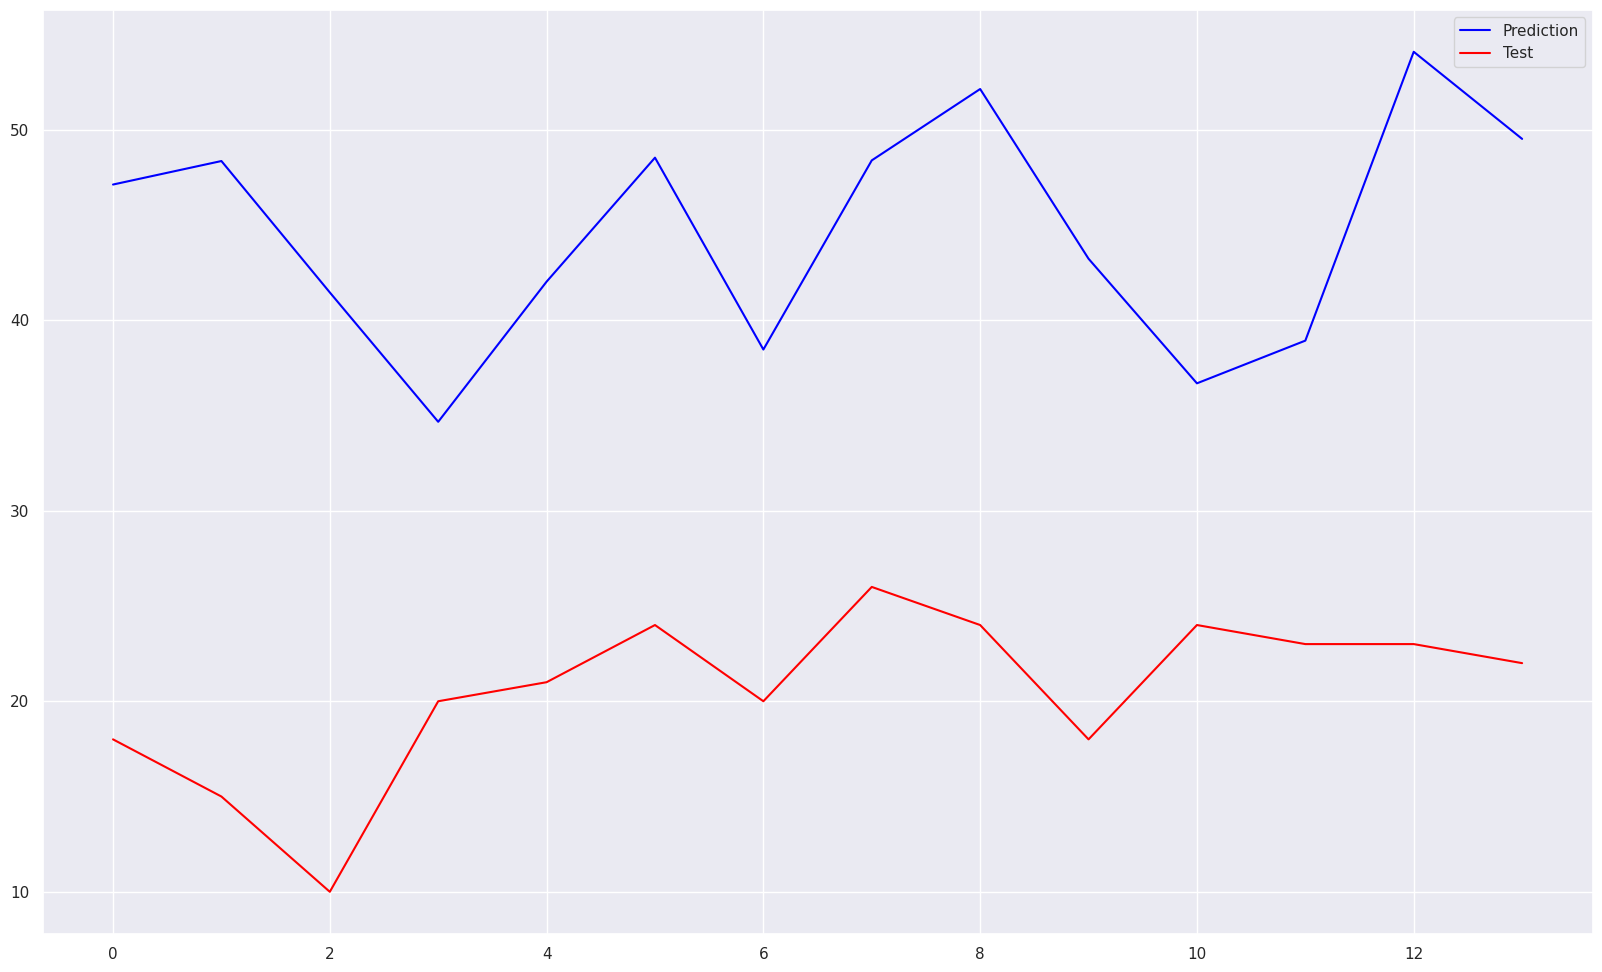

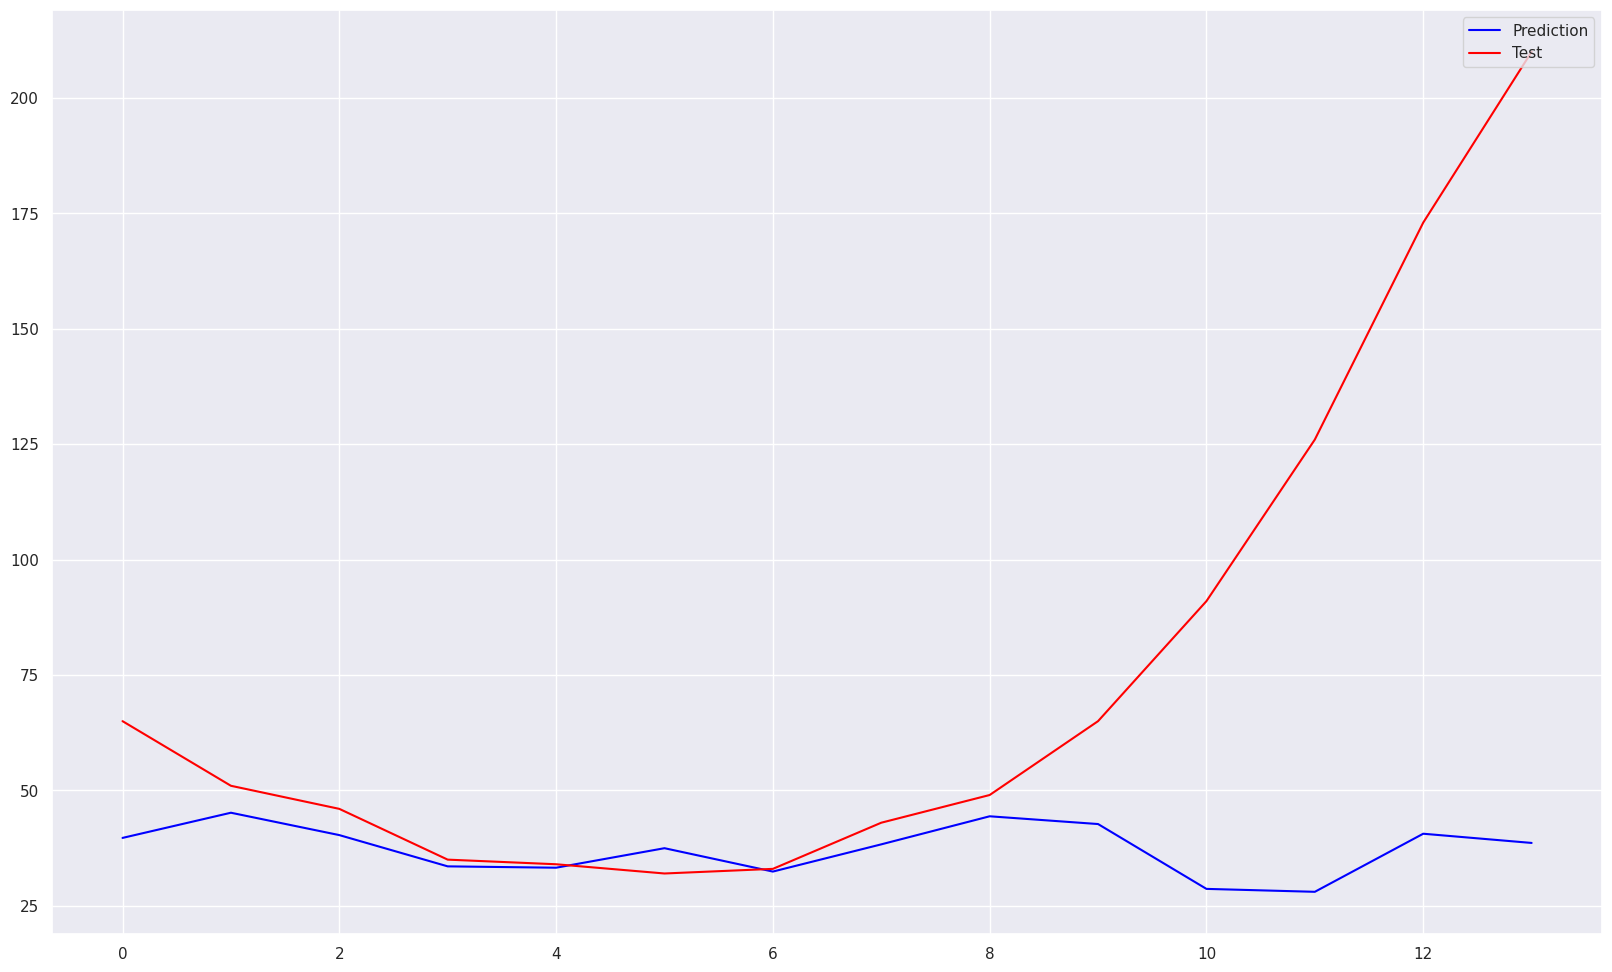

In [43]:
for i in range(tgv_y_pred.shape[0]):
    fig = plt.gcf(); fig.set_size_inches(20, 12);
    plt.plot(tgv_y_pred[i, :], c="blue", label="Prediction")
    plt.plot(tgv_y_test[i, :], c="red", label="Test")
#     plt.ylim(0, 430)
    plt.legend(loc='upper right')
    plt.show();

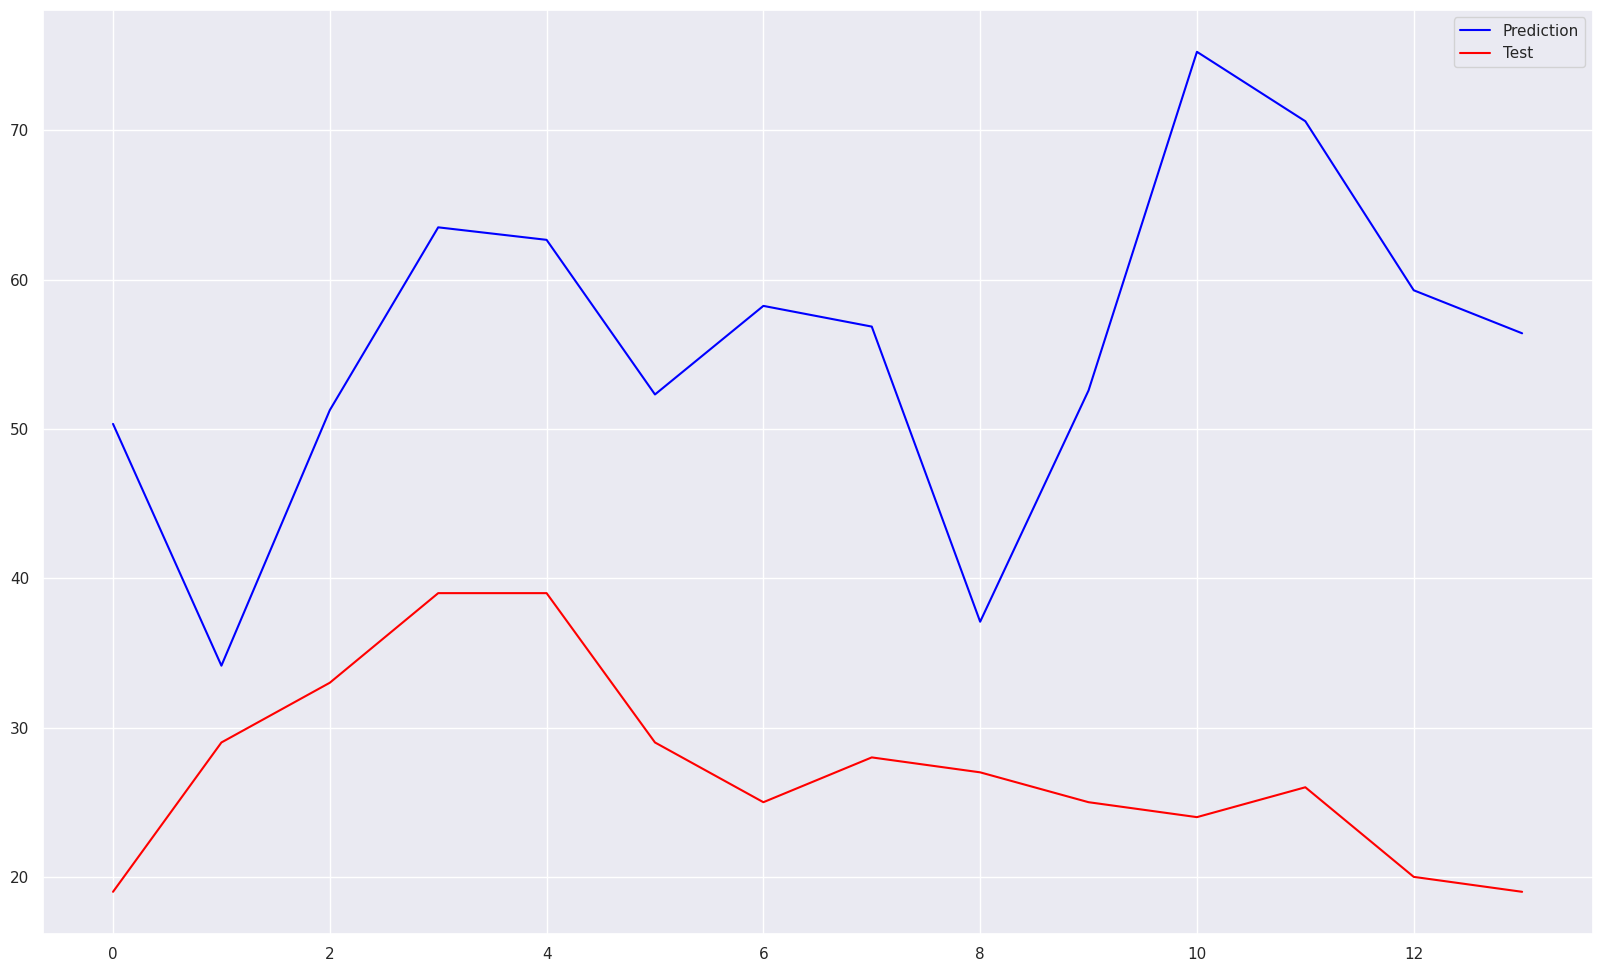

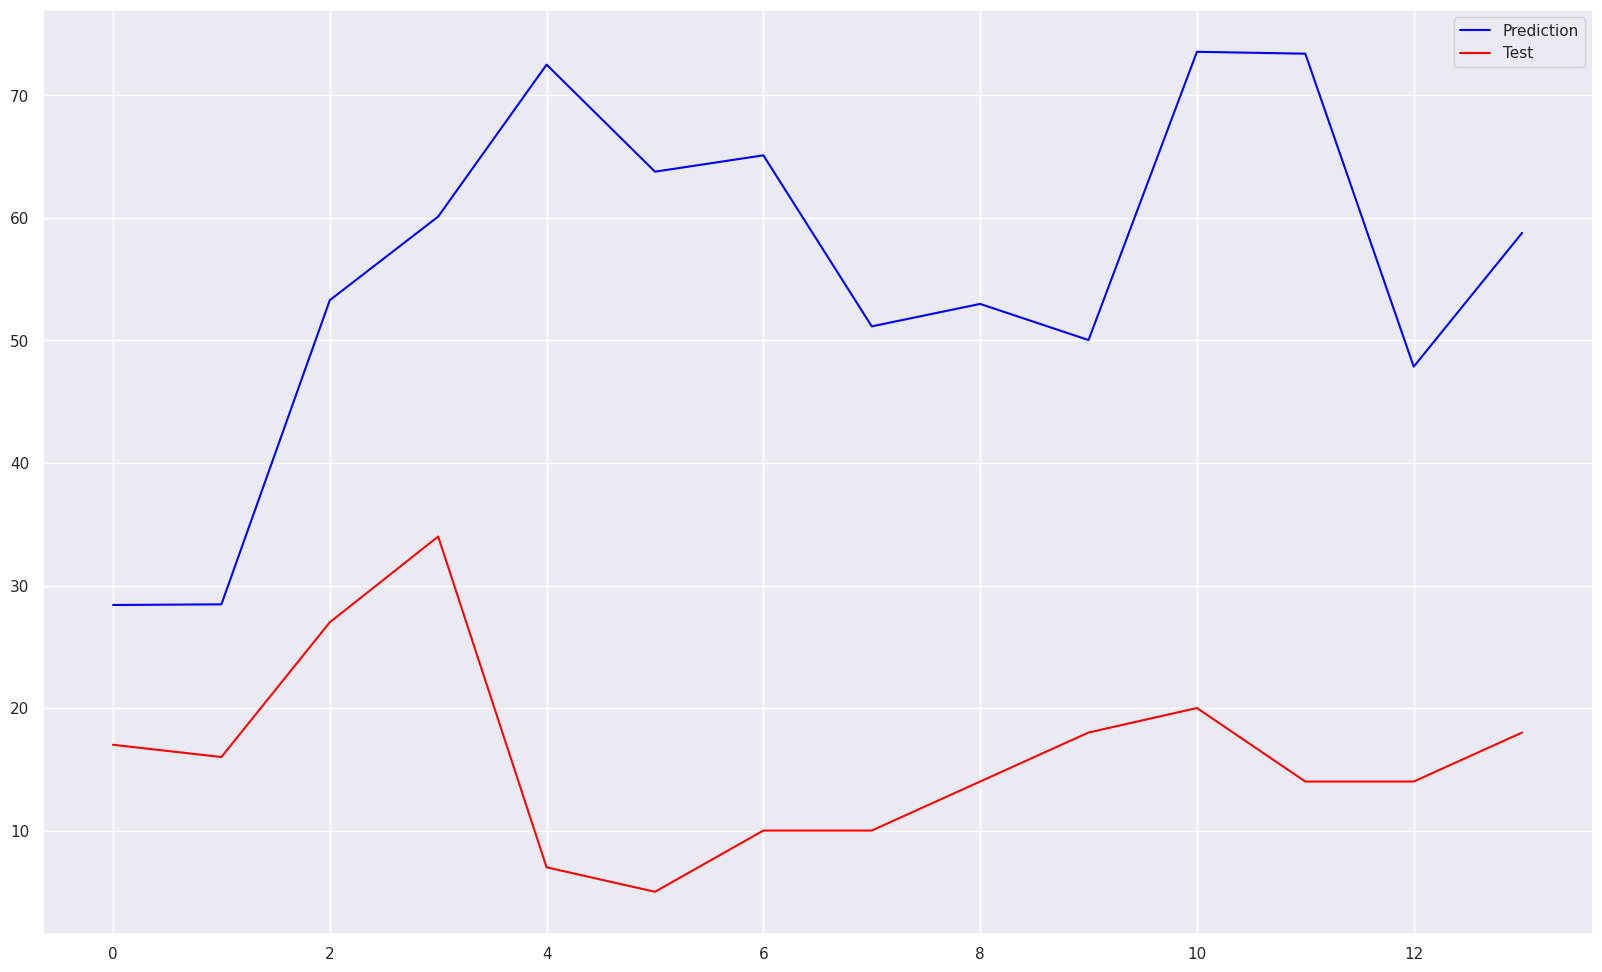

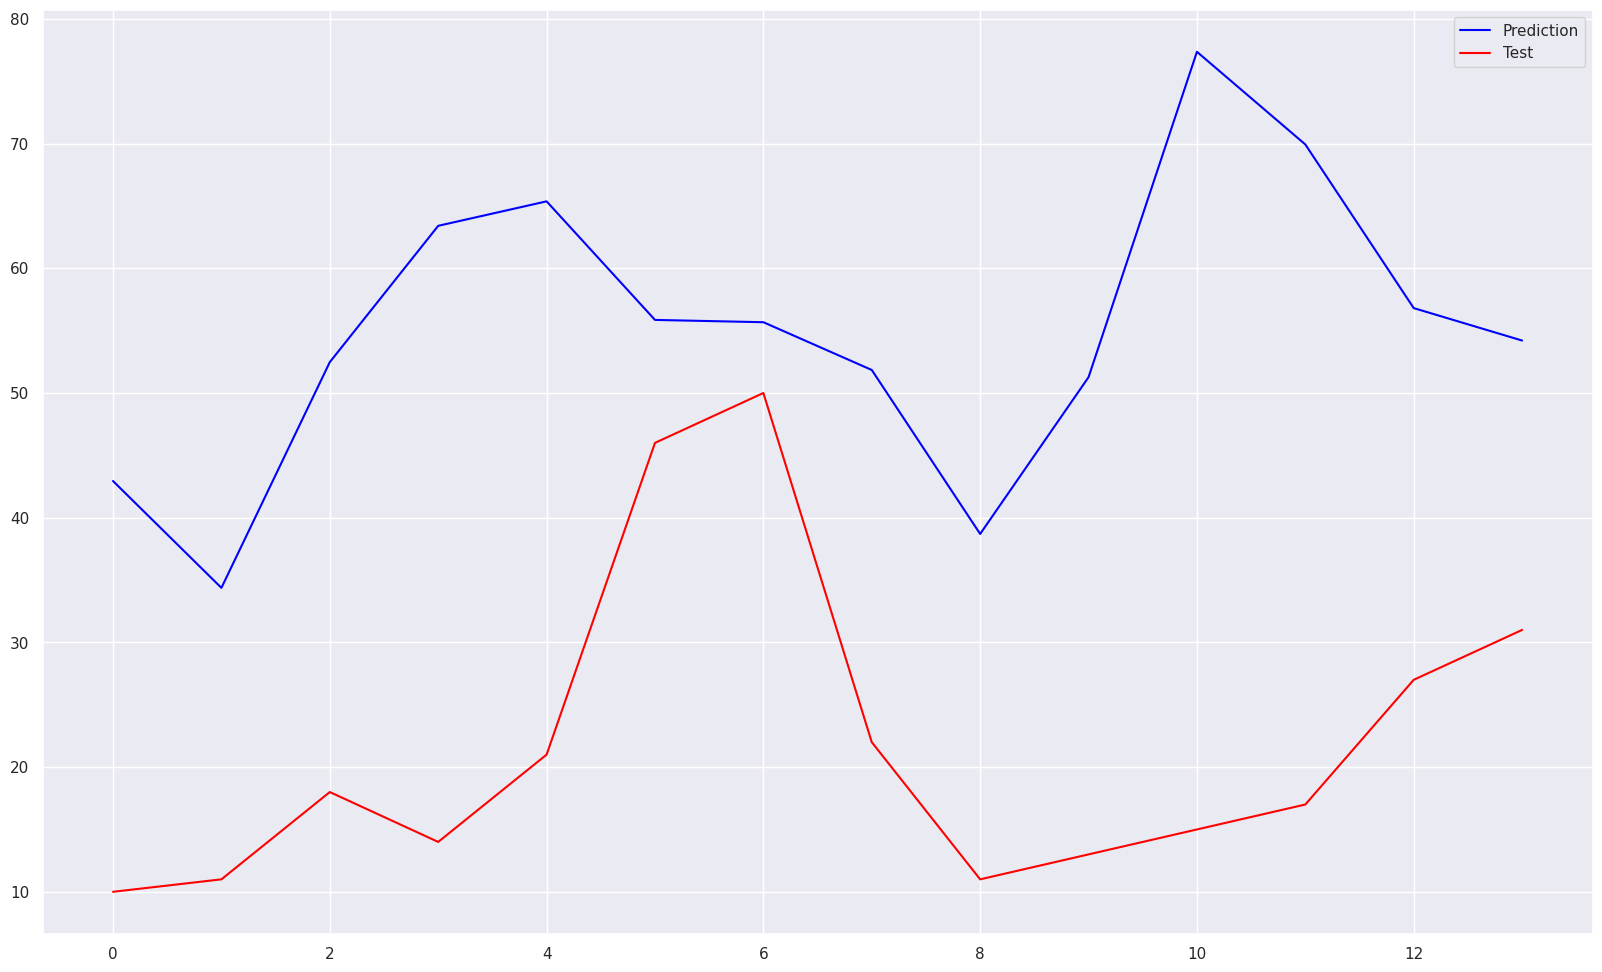

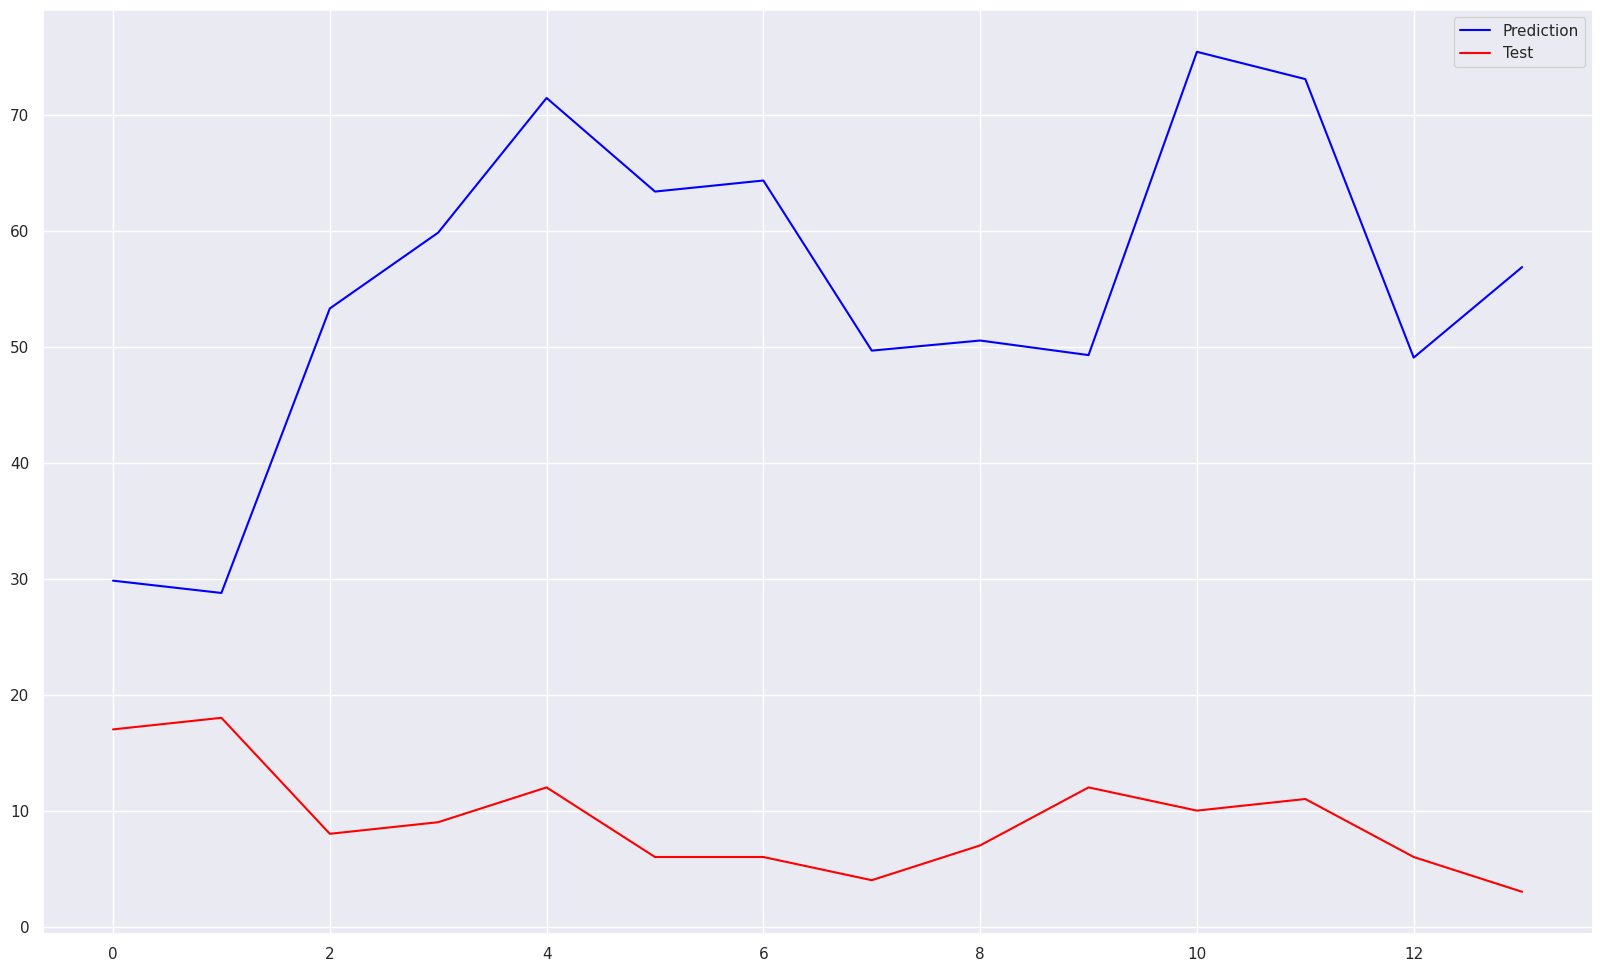

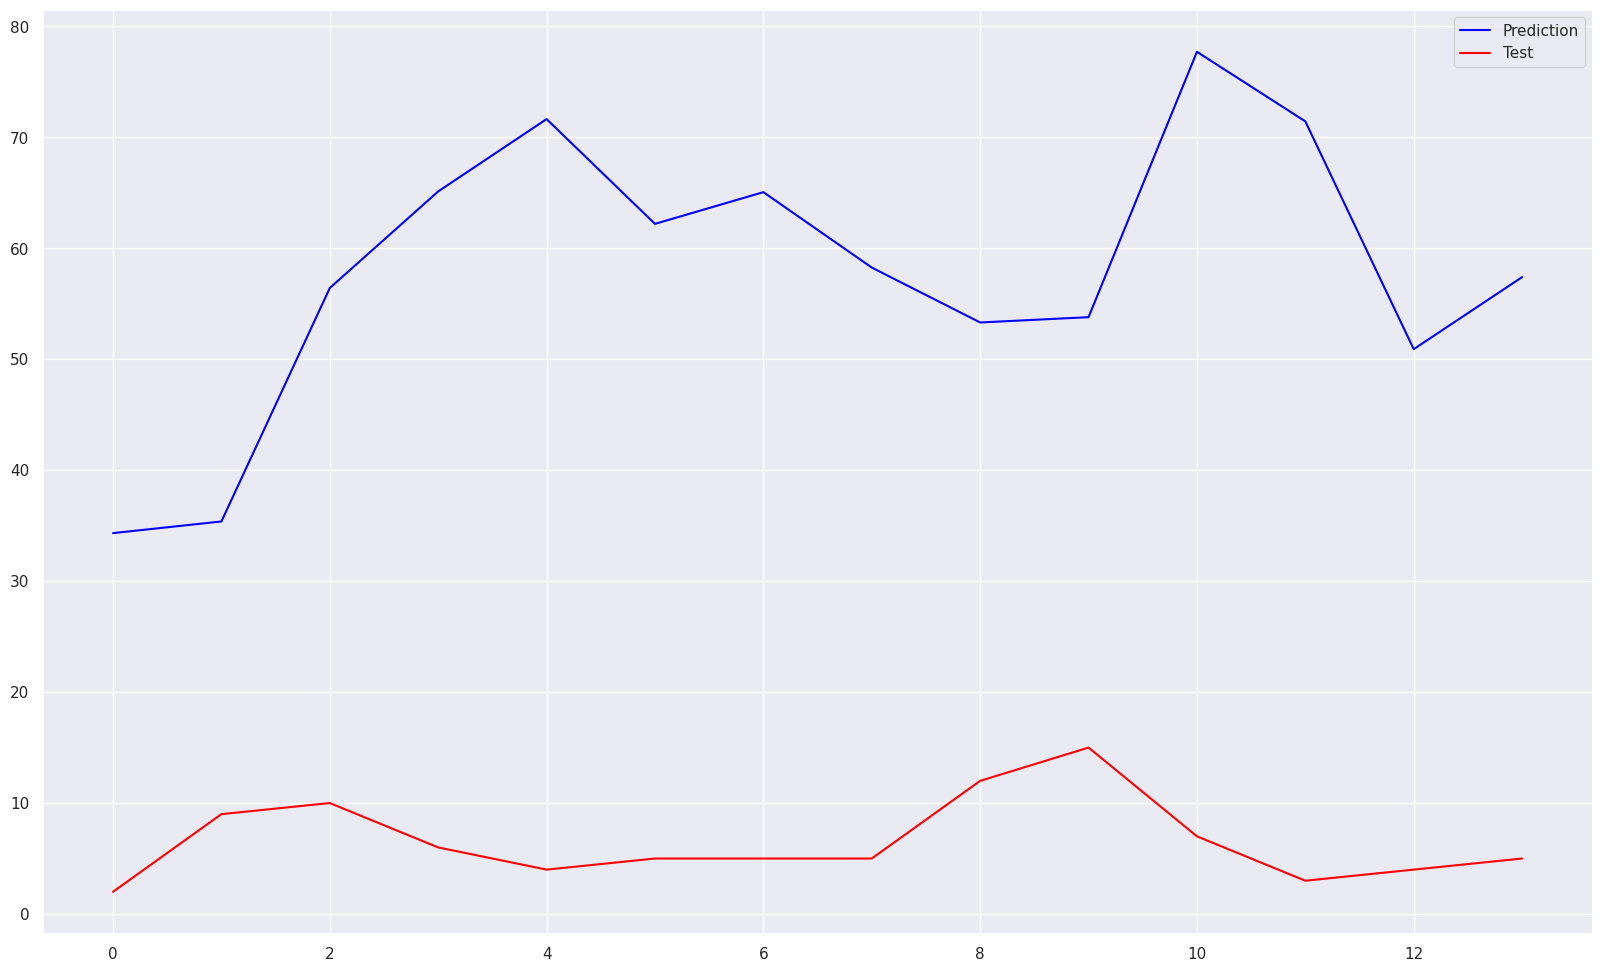

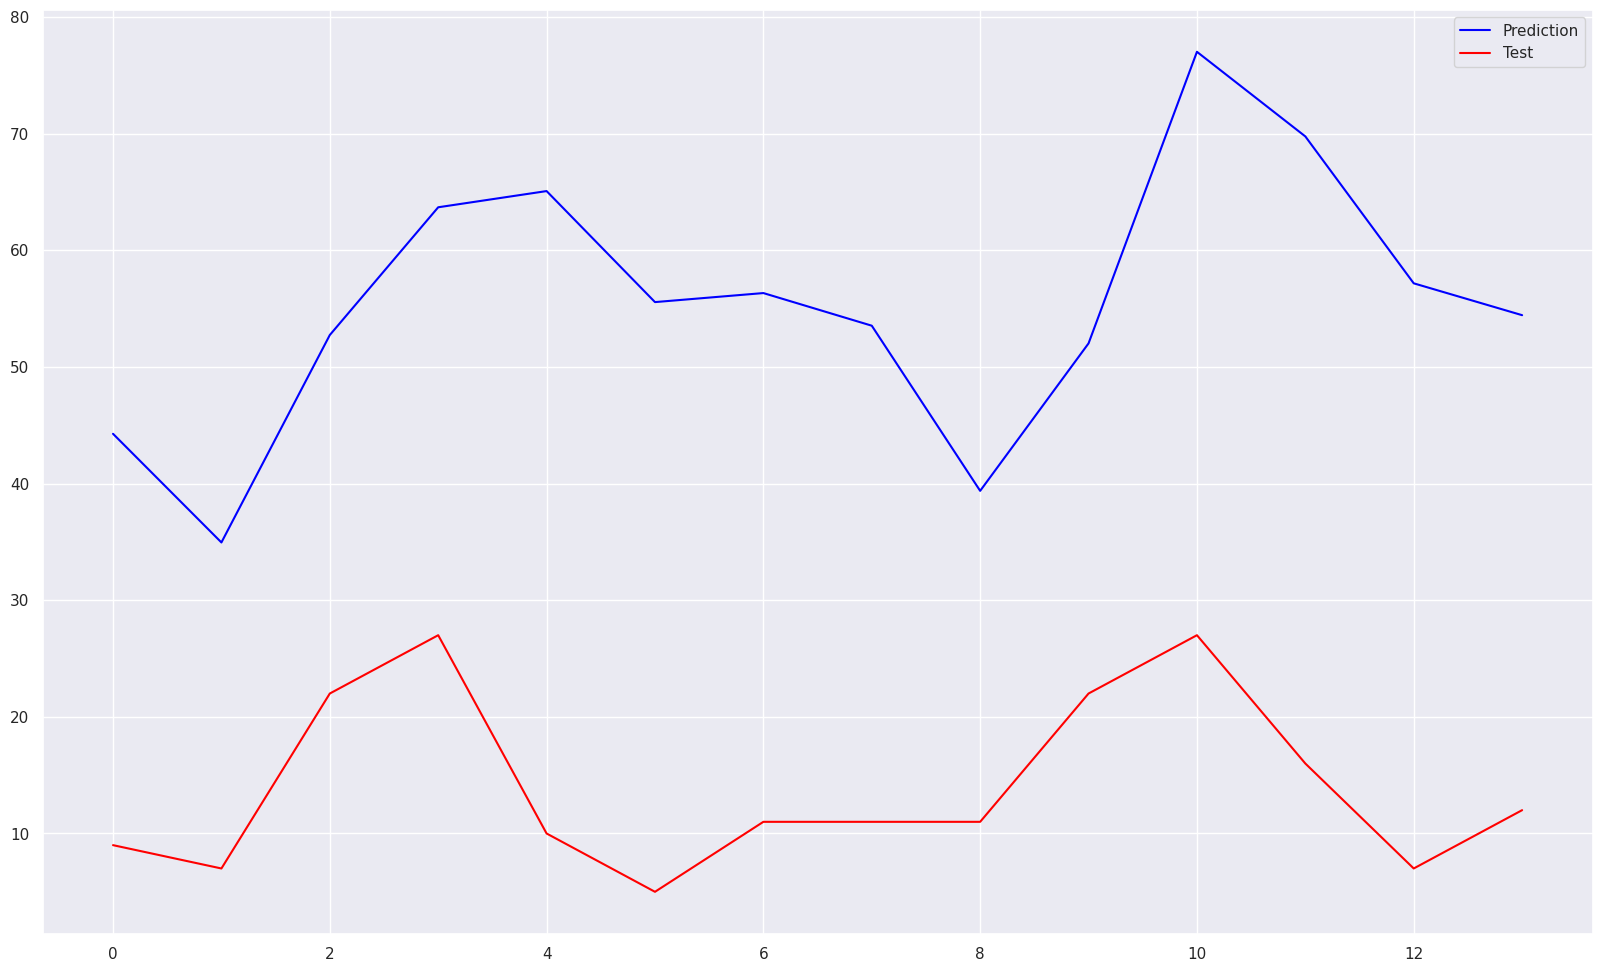

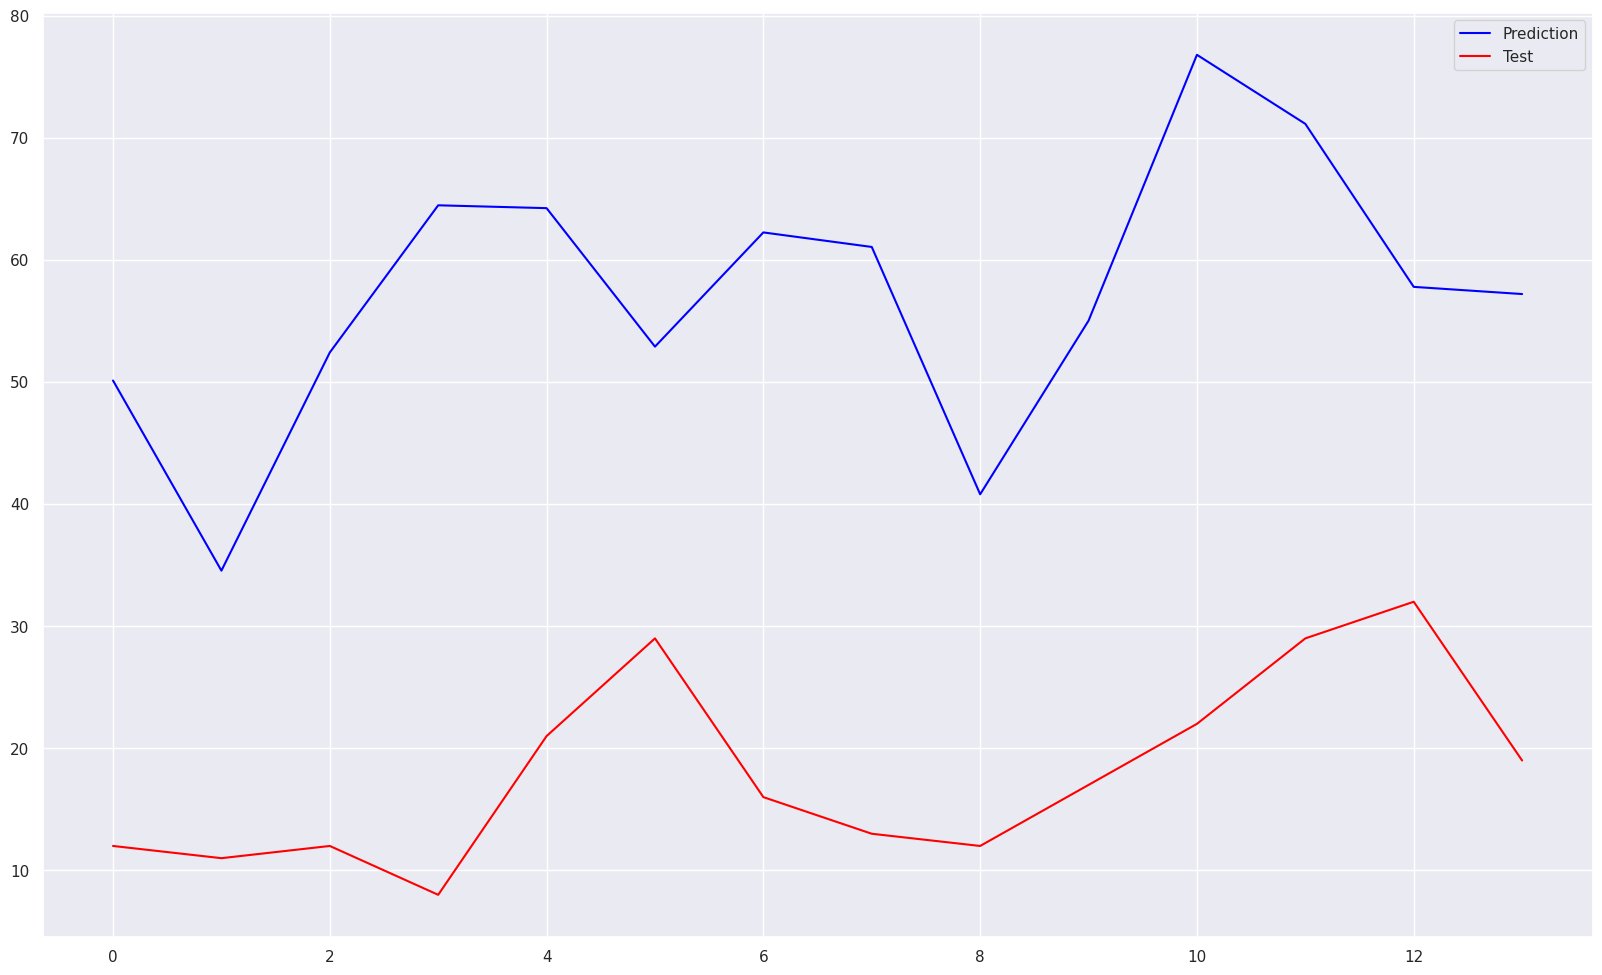

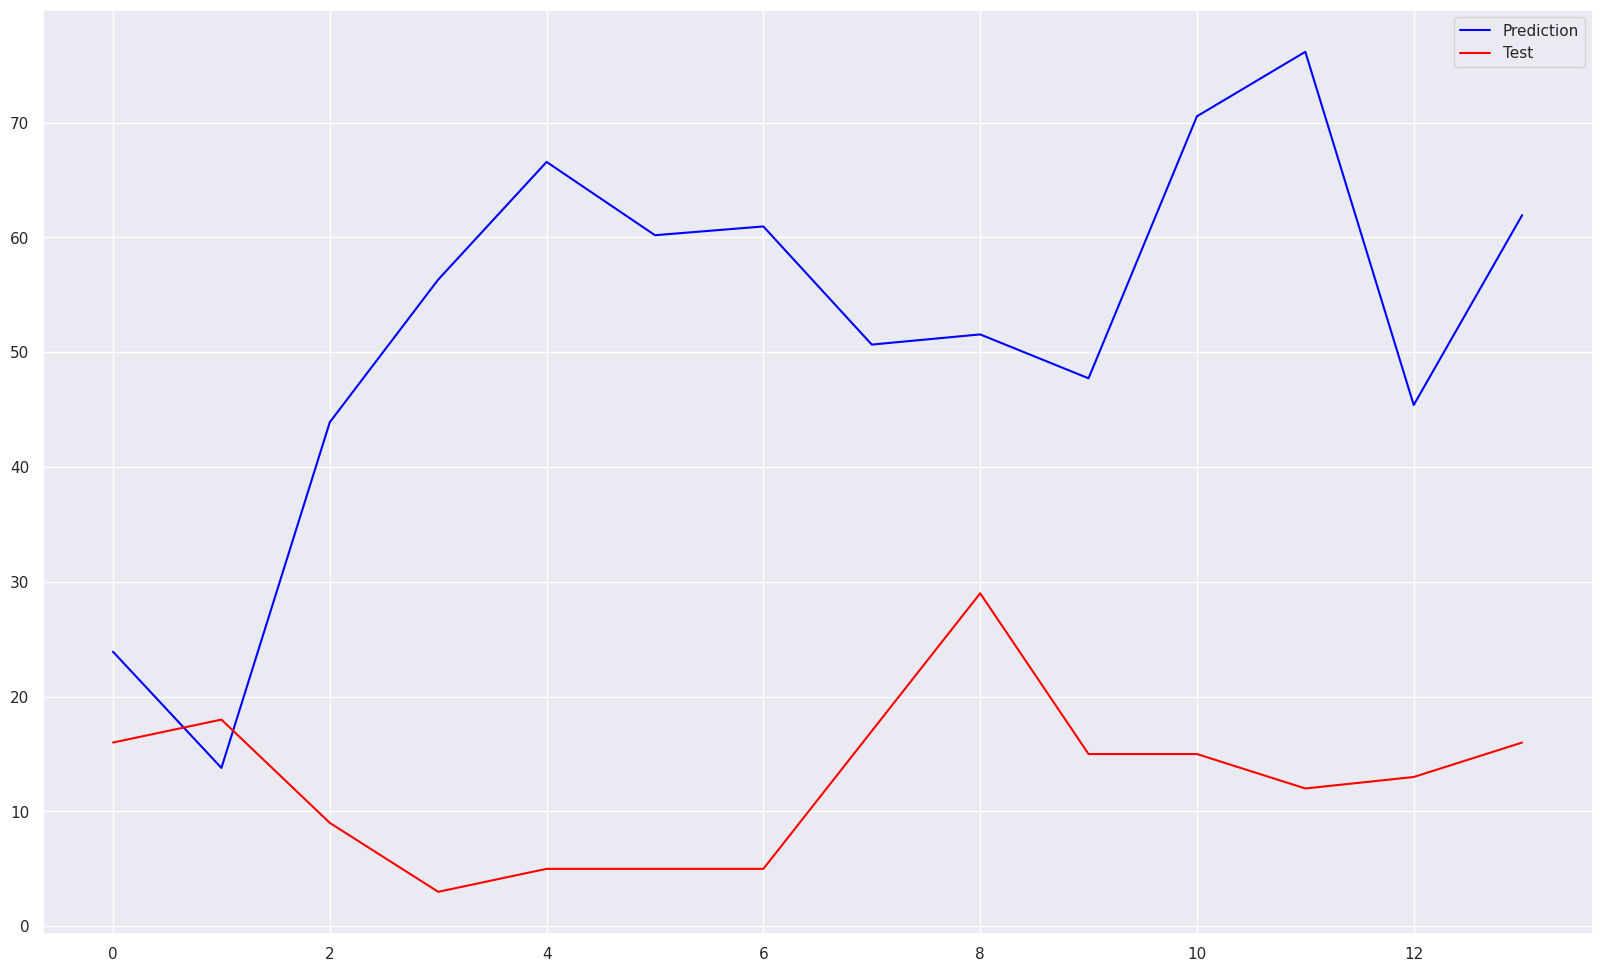

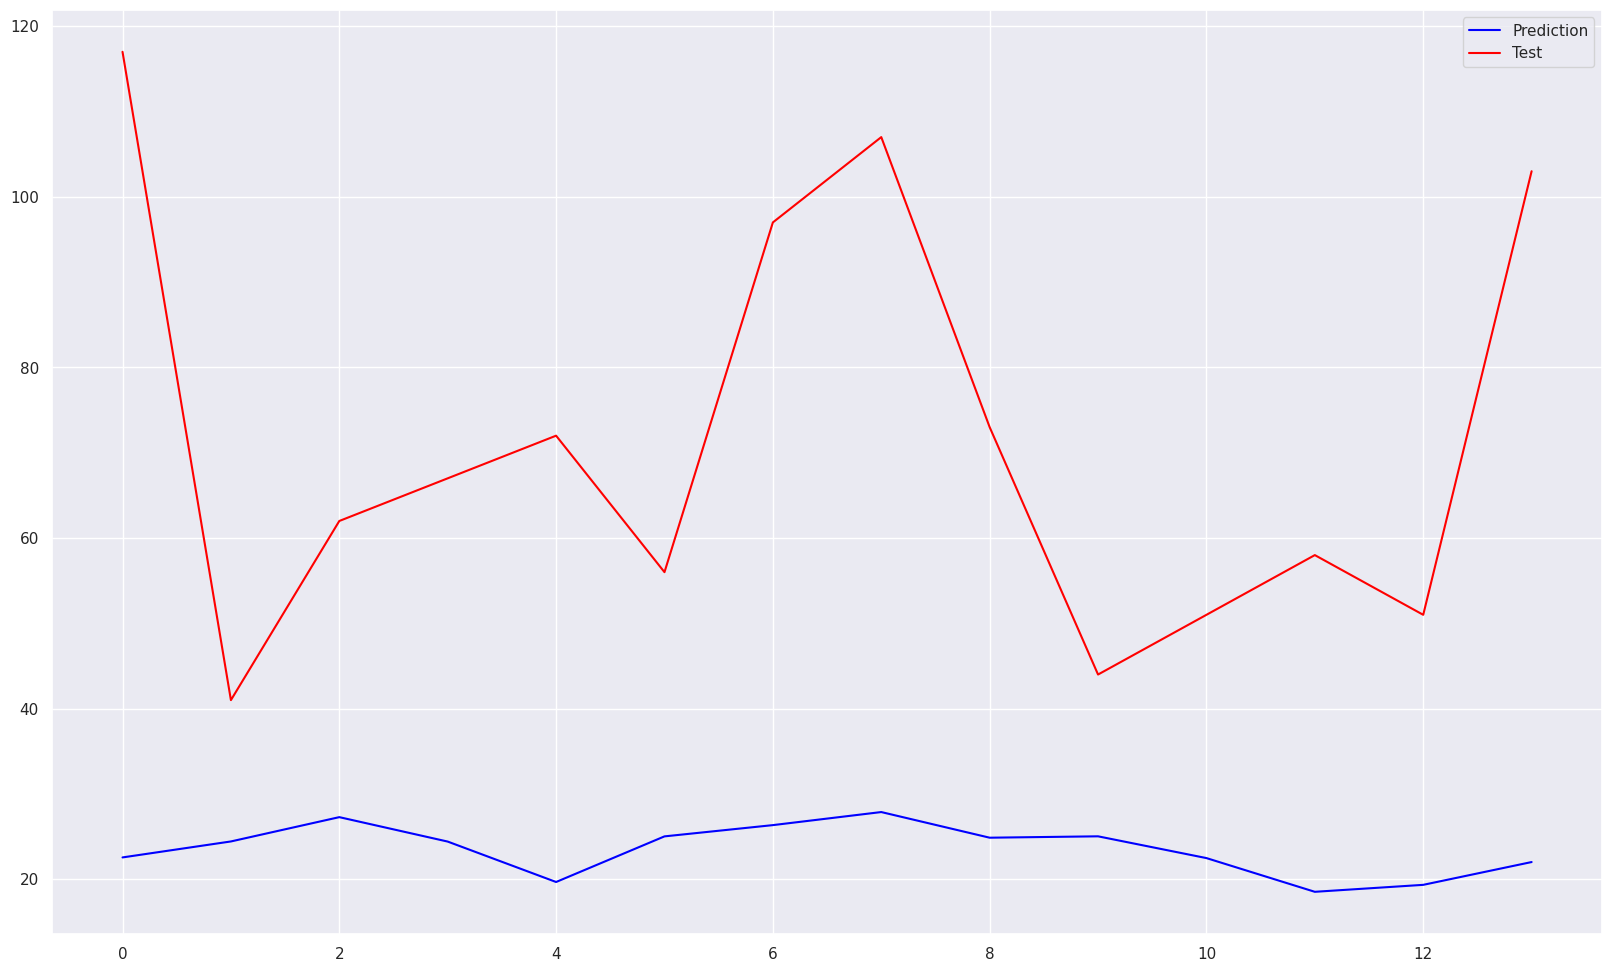

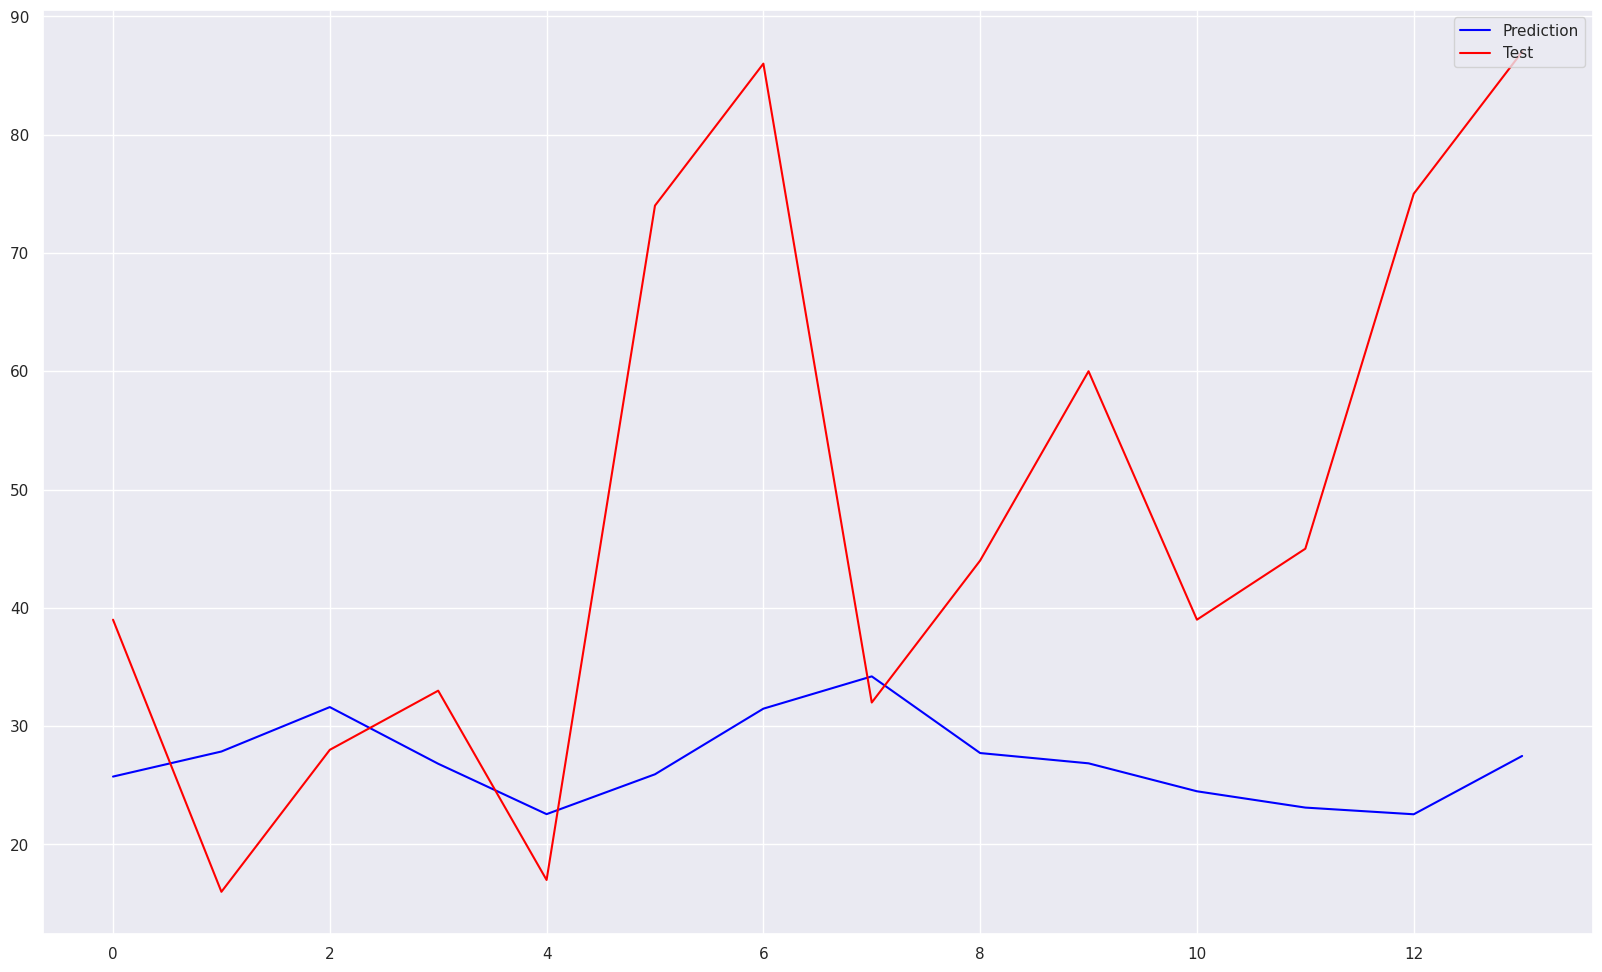

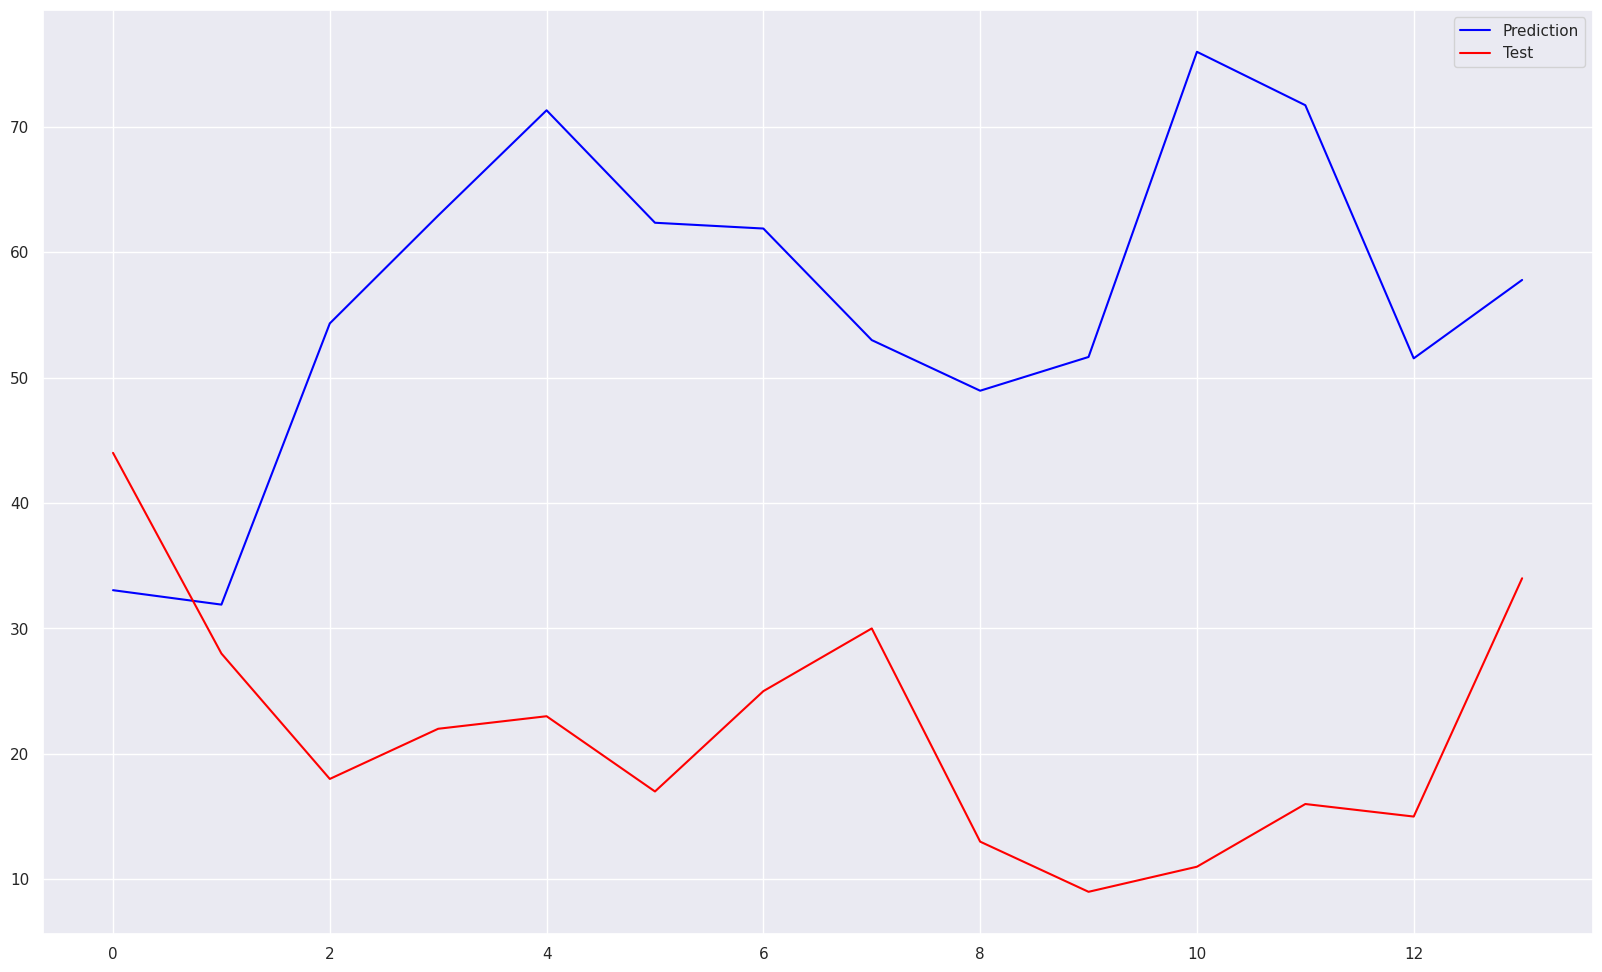

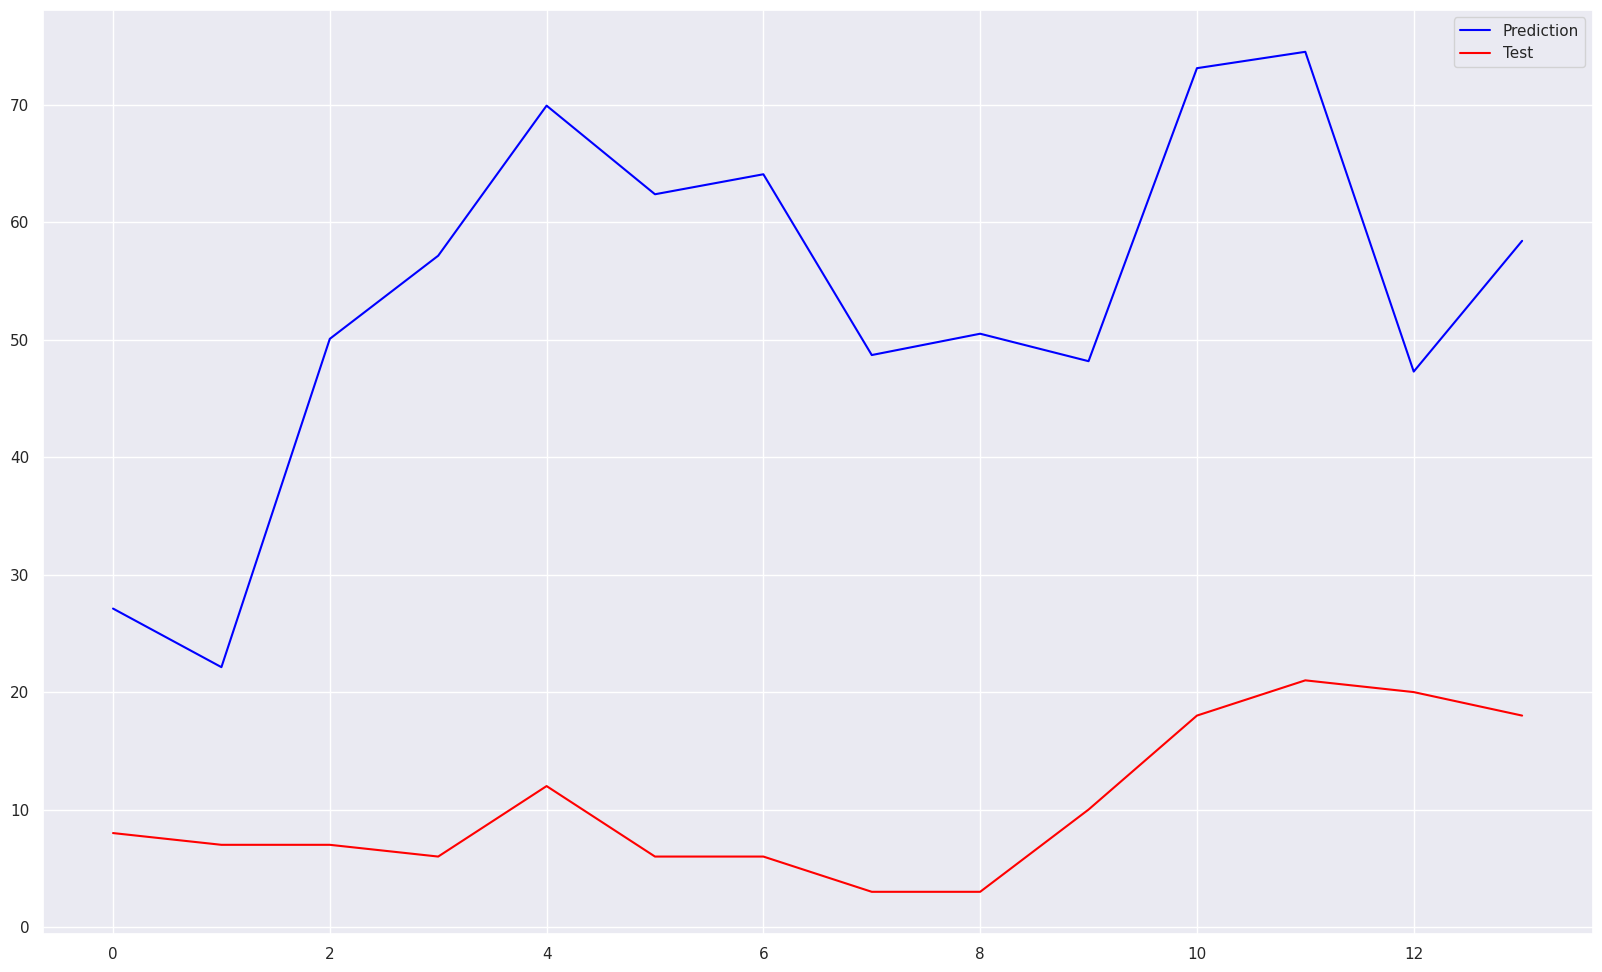

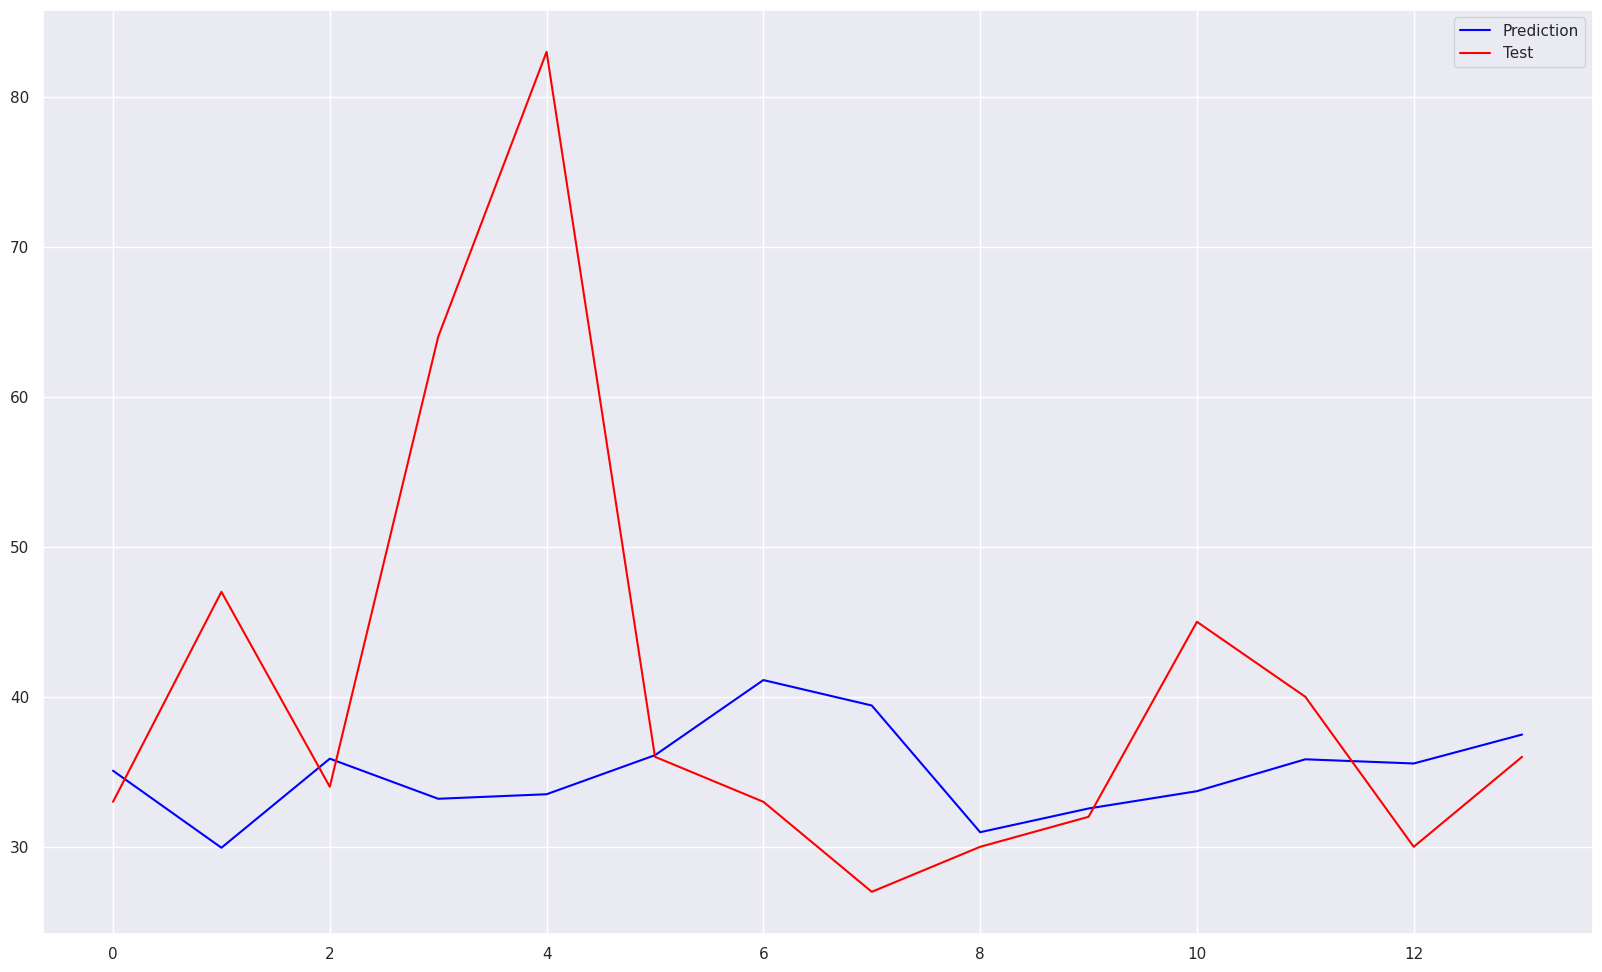

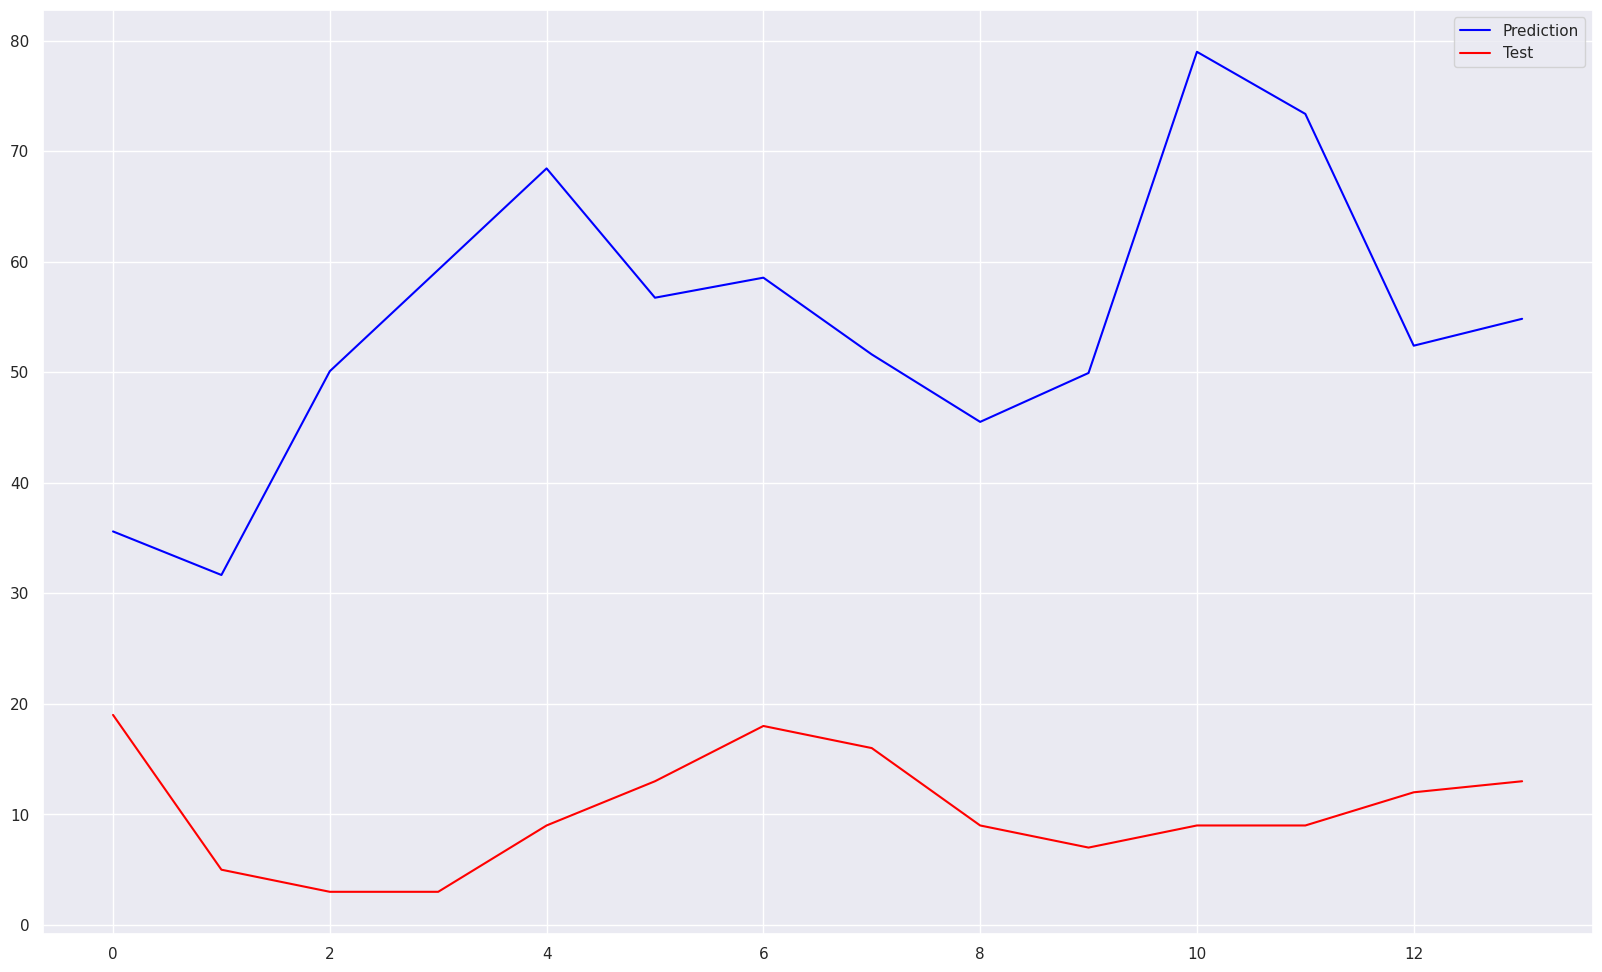

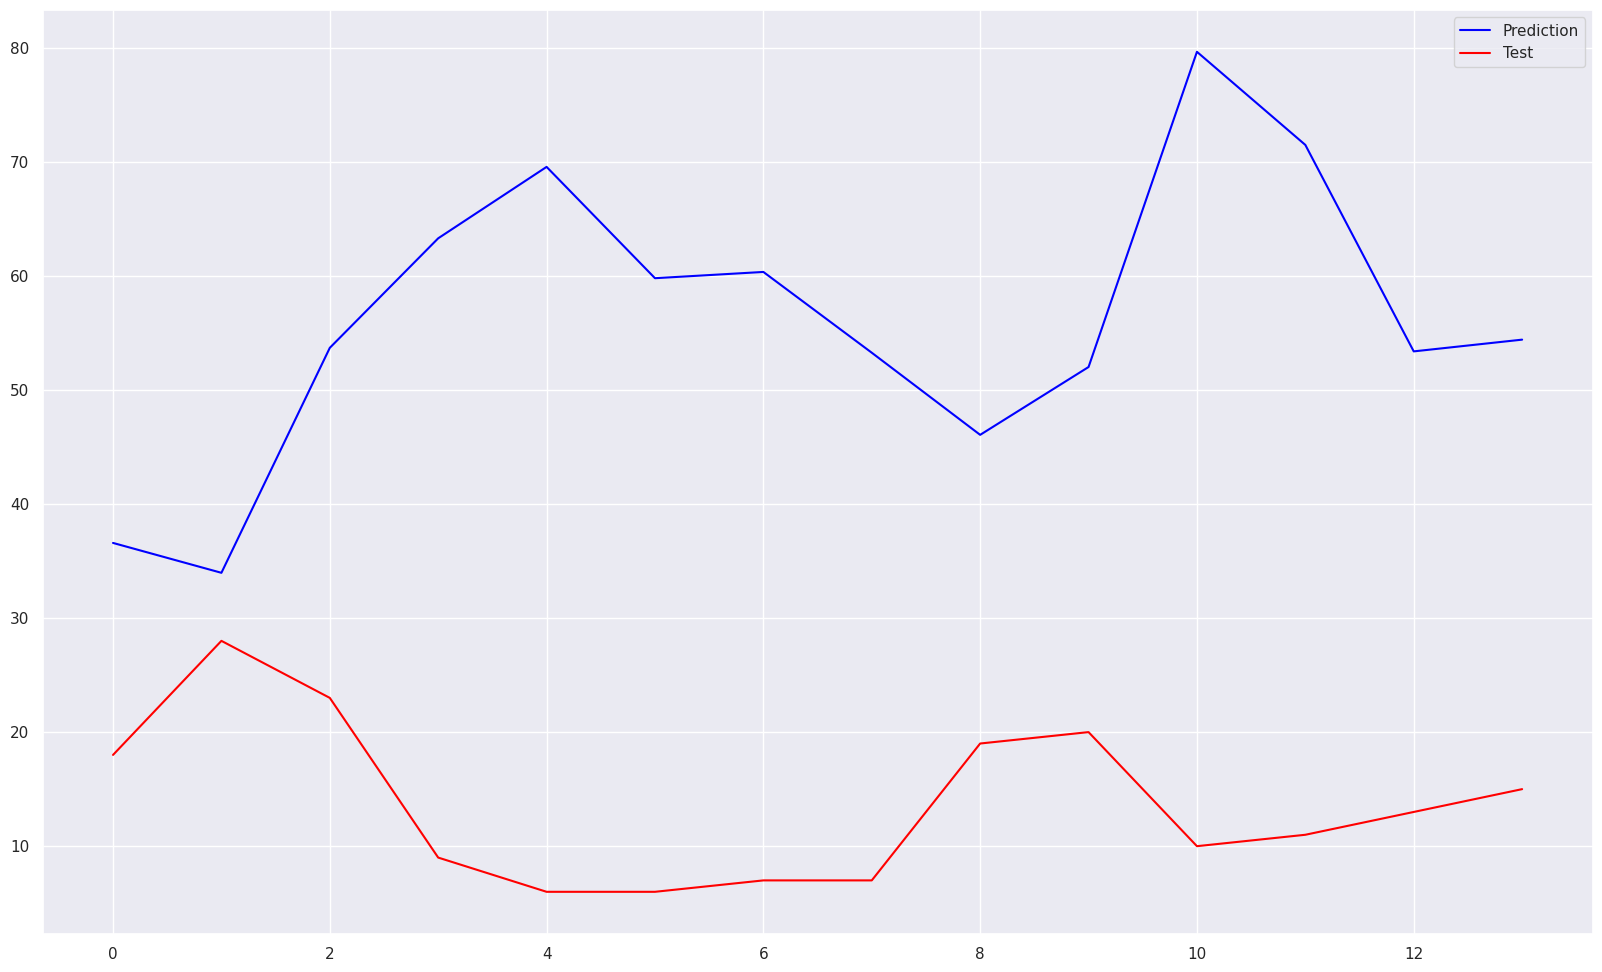

In [44]:
for i in range(city_y_pred.shape[0]):
    fig = plt.gcf(); fig.set_size_inches(20, 12);
    plt.plot(city_y_pred[i, :], c="blue", label="Prediction")
    plt.plot(city_y_test[i, :], c="red", label="Test")
#     plt.ylim(0, 430)
    plt.legend(loc='upper right')
    plt.show();

In [45]:
tgv_dl_error = np.mean(abs(tgv_y_pred - tgv_y_test))

In [46]:
city_dl_error = np.mean(abs(city_y_pred - city_y_test))


In [47]:
tgv_base_error = np.mean(abs((tgv_df[['nb_cars']]-tgv_df[['nb_cars']].shift(14)).dropna()))[0]
tgv_base_error

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


25.50786817102138

In [48]:
city_base_error = np.mean(abs((city_df[['nb_cars']]-city_df[['nb_cars']].shift(14)).dropna()))[0]
city_base_error

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


10.033437360677663

In [49]:
print(
    f"tgv model predicts with an average error of        {round(tgv_dl_error, 2)} cars"
    "\n"
    f"2 Weeks before predicts with an average error of  {round(tgv_base_error, 2)} cars"
)

tgv model predicts with an average error of        47.04 cars
2 Weeks before predicts with an average error of  25.51 cars


In [50]:
print(
    f"city model predicts with an average error of        {round(city_dl_error, 2)} cars"
    "\n"
    f"2 Weeks before predicts with an average error of  {round(city_base_error, 2)} cars"
)

city model predicts with an average error of        37.91 cars
2 Weeks before predicts with an average error of  10.03 cars


In [51]:
def plot_history(history):

    fig, ax = plt.subplots(1,2, figsize=(20,7))
    # --- LOSS: LOSS ---
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Loss')
    ax[0].set_ylabel('LOSS')
    ax[0].set_xlabel('EPOCH')
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- METRICS: MAE ---

    ax[1].plot(history.history['mae'])
    ax[1].plot(history.history['val_mae'])
    ax[1].set_title('Mean Absolute Error')
    ax[1].set_ylabel('LOSS')
    ax[1].set_xlabel('EPOCH')
    ax[1].legend(['Train', 'Validation'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    return ax

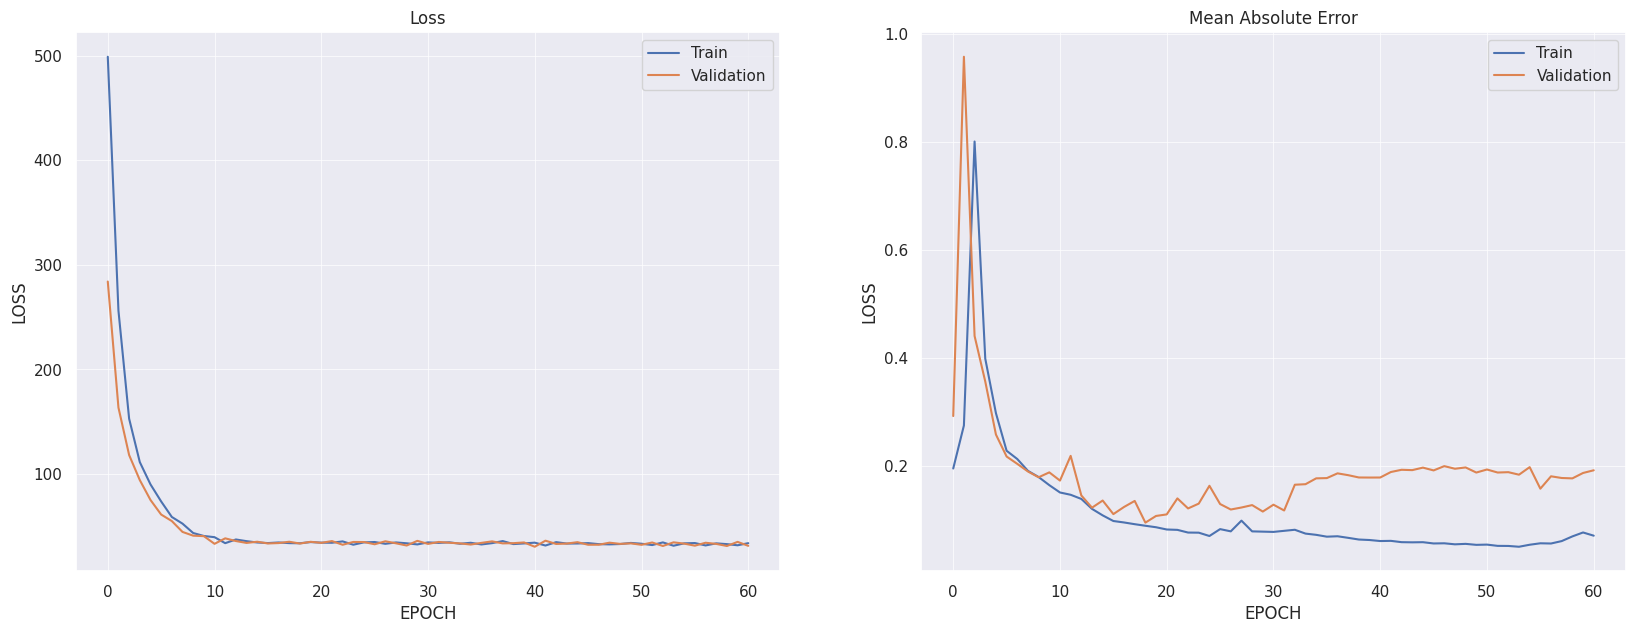

In [52]:
plot_history(tgv_history);

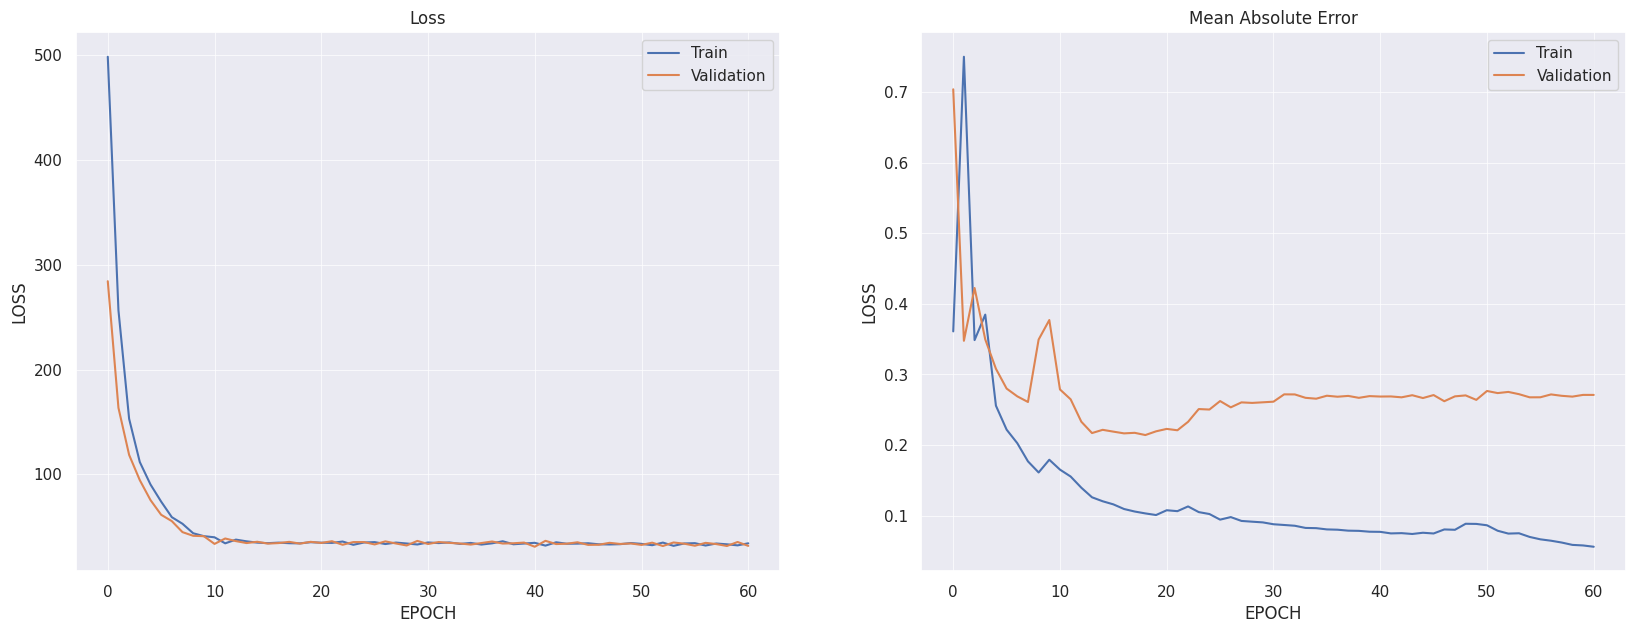

In [53]:
plot_history(city_history);

In [54]:
# Predict

In [55]:
# Create a dictionary of dataframes for the lst 56 days
df_dict_last_56 = {}
for key, value in df_dict.items():
  df_dict_last_56[f'{key}'] = value.tail(56)

In [56]:
#Predict for pocket #25
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
y_scaler.fit(df_dict_last_56['df_25'][['nb_cars']])

tgv_df_25_last_56_scaled = scaler.fit_transform(df_dict_last_56['df_25'])
pca = PCA(n_components=30).fit(tgv_df_25_last_56_scaled)
tgv_df_25_last_56_scaled_proj = pd.DataFrame(pca.transform(tgv_df_25_last_56_scaled))
tgv_df_25_last_56_scaled_proj.index = df_dict_last_56['df_25'].index


tgv_df_25_last_56_y_pred = tgv_model.predict(np.array(tgv_df_25_last_56_scaled_proj).reshape(1,56,30))


y_scaler.inverse_transform(tgv_df_25_last_56_y_pred).tolist()

1/1 [==============================] - 0s 61ms/step


[[13.200557708740234,
  13.339128494262695,
  12.82259750366211,
  11.438260078430176,
  11.770547866821289,
  11.866360664367676,
  10.897637367248535,
  10.856790542602539,
  10.358375549316406,
  9.574625968933105,
  9.123741149902344,
  9.71023941040039,
  10.209517478942871,
  10.924561500549316]]

In [57]:
def get_tgv_pred(pocket_number:int):
  '''
  Returns a prediction of number of cars for 14 days from pocket number
  '''
  #Scaling
  scaler = MinMaxScaler()
  y_scaler = MinMaxScaler()
  y_scaler.fit(df_dict_last_56['df_25'][['nb_cars']])
  scaled_df = scaler.fit_transform(df_dict_last_56[f'df_{pocket_number}'])

  #PCA
  pca = PCA(n_components=30).fit(scaled_df)
  proj = pd.DataFrame(pca.transform(scaled_df))
  proj.index = df_dict_last_56[f'df_{pocket_number}'].index

  tgv_df_25_last_56_y_pred = tgv_model.predict(np.array(tgv_df_25_last_56_scaled_proj).reshape(1,56,30))


  return y_scaler.inverse_transform(tgv_df_25_last_56_y_pred).tolist()


In [58]:
get_tgv_pred(875)

1/1 [==============================] - 0s 57ms/step


[[13.200557708740234,
  13.339128494262695,
  12.82259750366211,
  11.438260078430176,
  11.770547866821289,
  11.866360664367676,
  10.897637367248535,
  10.856790542602539,
  10.358375549316406,
  9.574625968933105,
  9.123741149902344,
  9.71023941040039,
  10.209517478942871,
  10.924561500549316]]

In [59]:
csv_list = [25, 34, 36, 52, 95, 180, 206, 272, 287, 368, 781, 875, 1435, 5435, 6287]

In [60]:
tgv_model.save('tgv_model_1')

In [61]:
from google.colab import files
files.download('tgv_model_1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [62]:
from tensorflow import keras

In [63]:
new_model = keras.models.load_model('tgv_model_1')

# Show the model architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 56, 200)           184800    
                                                                 
 lstm_1 (LSTM)               (None, 56, 200)           320800    
                                                                 
 lstm_2 (LSTM)               (None, 56, 200)           320800    
                                                                 
 lstm_3 (LSTM)               (None, 56, 200)           320800    
                                                                 
 lstm_4 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 14)                2814      
                                                                 
Total params: 1,470,814
Trainable params: 1,470,814
Non-

In [64]:
#tgv_df_25_last_56_y_pred = tgv_model.predict(np.array(tgv_df_25_last_56_scaled_proj).reshape(1,56,30))


new_model.predict(np.array(tgv_df_25_last_56_scaled_proj).reshape(1,56,30))
y_scaler.inverse_transform(tgv_df_25_last_56_y_pred).tolist()

1/1 [==============================] - 2s 2s/step


[[13.200557708740234,
  13.339128494262695,
  12.82259750366211,
  11.438260078430176,
  11.770547866821289,
  11.866360664367676,
  10.897637367248535,
  10.856790542602539,
  10.358375549316406,
  9.574625968933105,
  9.123741149902344,
  9.71023941040039,
  10.209517478942871,
  10.924561500549316]]